<a href="https://colab.research.google.com/github/nando-cezar/pandora/blob/developer/pandora_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

> EM-DAT will be used, which is a global database that records information about natural and technological disasters. It is maintained by the Disaster Epidemiology Research Center (CRED) at the Catholic University of Louvain, Belgium. EM-DAT provides data on the occurrence, impact and response to disasters since the beginning of the 20th century.

> Data analysis will be separated by category and continental regions, namely:

*   Dry
*   Flood
*   Extreme temperature
*   Mist
*   Storm







# Importing libraries


In [148]:
!pip3 install opencage

In [149]:
import pandas as pd
from google.colab import drive
from time import sleep
import warnings
import requests
import json
from pandas import json_normalize
import seaborn as sns
from google.colab import userdata
from opencage.geocoder import OpenCageGeocode


warnings.simplefilter("ignore")
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# EM-DAT: Reading the file


> Restricting reading to the following columns: location, start date and end date.

In [150]:
df = pd.read_excel(f"{userdata.get('notebook_path')}/{userdata.get('file_path')}.xlsx", sheet_name=[0, "EM-DAT Data"], usecols='K, N, Z, AA, AB, AC, AD, AE')

# EM-DAT: File handling


> Performing row removal with NaN

In [151]:
_data_type = {'Country': str, 'Location': str, 'Start Year': int, 'Start Month': int, 'Start Day': int, 'End Year': int, 'End Month': int, 'End Day': int}
df = df['EM-DAT Data'].fillna(0).astype(_data_type)

## EM-DAT: Data visualization without processing

In [152]:
display(df)

Country                                           Location  \
0       Bolivia                    Cochabamba, Santa Cruz, La Paz    
1     Argentina       Buenos Aires, Sante Fe, Formosa, Santa Cruz    
2       Uruguay                               Paysandu, Maldonado    
3         Chile  Antofagasta, Araucania, Arica y Parinacota, At...   
4        Brazil                              Porto Alegre district   
5      Paraguay  Alto Paraguay, Alto Parana, Amambay, Boqueron,...   
6        Mexico                                 Chihuahua province   
7     Argentina  Chubut, Neuquen, Rio Negro, Catamarca, Buenos ...   
8      Bolivia                  La Paz, Oruro, Cochabamba, Potosi    
9     Guatemala  El Progreso, Jalapa, Chiquimula, Zacapa, Jutiapa    
10    Argentina  Catamarca, Chaco, Corrientes, Formosa, Jujuy, ...   
11        Chile  Aisen del General Carlos Ibañez del Campo, Ant...   
12       Mexico  Chihuahua, Sonora, Baja California, Baja Calif...   
13         Peru  Ayacucho, Huancavelica, Tacna, Moquegua, Arequ...   
14       Mexico  Chihuahua, Puebla, Nuevo Leon, Hidalgo, Sonora...   
15    Argentina                                 Mar del Plata city   
16       Brazil                            Santa Catarina, Parana    
17        Chile  Aisen del General Carlos Ibañez del Campo, Ant...   
18         Peru  Ancash, Puno, Cusco, Arequipa, Moquegua, Tacna...   
19     Paraguay  Alto Paraguay, Alto Parana, Amambay, Boqueron,...   
20      Uruguay                                        Montevideo    
21       Mexico                                         Chihuahua    
22    Guatemala  Alta Verapaz, Baja Verapaz, Chimaltenango, Chi...   
23       Mexico  Aguascalientes, Baja California, Baja Californ...   
24  El Salvador                              Santa Tecla district    
25         Peru  Amazonas, Ancash, Apurimac, Arequipa, Ayacucho...   
26    Argentina  Buenos Aires, Buenos Aires D.f., Catamarca, Ch...   
27      Bolivia                                Santa Cruz province   
28        Chile   Aisen del Gral. Carlos Ibañez del Campo province   
29     Paraguay  Alto Paraguay, Alto Parana, Amambay, Boqueron,...   
30      Uruguay  Artigas, Canelones, Cerro Largo, Colonia, Dura...   
31         Peru  Ancash, Apurimac, Arequipa, Ayacucho, Cusco, H...   
32       Mexico                       Sinaloa, Sonora, Tamaulipas    
33         Peru  Huancavelica, Cusco, Ayacucho, Arequipa, Moque...   
34    Guatemala  Huehuetenango, Quiche, San Marcos, Solola, Que...   
35         Peru                                          Arequipa    
36         Peru  Amazonas, Ancash, Apurimac, Arequipa, Ayacucho...   
37         Peru  Apurimac, Arequipa, Cusco, Huancavelica, Lima,...   

    Start Year  Start Month  Start Day  End Year  End Month  End Day  
0         2000            7          0      2000          7        0  
1         2000            6         17      2000          6       17  
2         2000            7          0      2000          7        0  
3         2000            7          3      2000          7        3  
4         2000            7          0      2000          7        0  
5         2000            7          0      2000          7        0  
6         2000           10          0      2000         10        0  
7         2001            7          0      2001          7        0  
8         2001            7          0      2001          7        0  
9         2001           11          0      2001         11        0  
10        2002            7          0      2002          7        0  
11        2002            7          0      2002          7        0  
12        2002           12         24      2002         12       24  
13        2003            7          7      2003          8       15  
14        2003           12          0      2003         12        0  
15        2004            7          0      2004          7        0  
16        2004            7          0      2004          7        0  

# Treatment: Algorithms for data processing and structure assembly

> Algorithm for processing data (Formatting date for the api model)



In [153]:
def date_format_API(date):
  return "-".join([str(int(item)).zfill(2) if isinstance(item, float) else str(item).zfill(2) for item in date])

> Algorithm for boxplot graph plating

In [154]:
def generate_bsplot(dataTable, title, xlabel, ylabel="Monitoring variables", width=20, heigth=5, boxplot_width=.4, stripplot_size=3):

    ax = sns.boxplot(data=dataTable, width=boxplot_width, orient='h', color=".8", linewidth=1.5, medianprops={"color": "r", "linewidth": 1})
    ax = sns.stripplot(data=dataTable, orient='h', size=stripplot_size)
    ax.figure.set_size_inches(width, heigth)

    ax.set_title(title, fontsize=15)
    ax.set_xlabel(f"Range of values ({xlabel})", fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=45)
    ax.grid()
    ax

> Algorithm for switch value

In [155]:
def switch_value(source, offset, target):
    return target if source == offset else source

> Algorithm for locality accuracy

In [156]:
def get_index(target, source, label):
    for index, item in enumerate(source):
        if target.strip() == item[label]:
            return index
    return 0

# GEOCODE MAPS: Load latitude and longitude information from API

> Algorithm for processing data (Search latitude and longitude from location)

In [157]:
geocoder = OpenCageGeocode(userdata.get('api_key_opencage_geocode'))

def search_location(query):
    response = geocoder.geocode(query)
    return response

#print(search_location("Sante Fe, Argentina")) --- Testing...

> Getting information and formatting dataframe


In [158]:
_locale_structure = []

def get_location_info(text_country, location):

    location_join = "".join([location, ", ", text_country])
    result = search_location(query=location_join)
    if result:
        index = get_index(target=location_join, source=result, label="formatted")
        if index > -1:
            location_info = {
                'Location': result[index]["formatted"],
                'Latitude': result[index]["geometry"]["lat"],
                'Longitude': result[index]["geometry"]["lng"]
            }
            return location_info

    return None

def process_location_info(infos):
    rdf = infos["Location"].split(',')

    if rdf:
        for location in rdf:
            location_info = get_location_info(infos["Country"], location)

            if location_info and location_info["Location"] != infos["Country"]:
                date_info = {
                    'Start Date': [infos['Start Year'], infos['Start Month'], switch_value(infos['Start Day'], 0, 1)],
                    'End Date': [infos['End Year'], infos['End Month'], switch_value(infos['End Day'], 0, 30)]
                }
                location_info.update(date_info)
                _locale_structure.append(location_info)

for _, infos in df.iterrows():
    process_location_info(infos)


## GEOCODE MAPS: Data visualization without processing

In [159]:
_data_type = {'Location': str, 'Latitude': str, 'Longitude': str, 'Start Date': object, 'End Date': object}
df = pd.DataFrame(_locale_structure).astype(_data_type)
display(df)

Location     Latitude  \
0                                  Cochabamba, Bolivia  -17.3330142   
1                                  Santa Cruz, Bolivia   -17.333333   
2               La Paz, Pedro Domingo Murillo, Bolivia  -16.4955455   
3                              Buenos Aires, Argentina  -37.1498403   
4    Sante Fe, Universitario, 8332 Municipio de Gen...  -39.0209899   
..                                                 ...          ...   
323                                     Moquegua, Peru   -16.833333   
324                                        Pasco, Peru        -10.5   
325                                         Puno, Peru        -15.0   
326                                        Tacna, Peru   -17.666667   
327  Oxígeno & Extintores Ayucucho, Jirón Cesar Val...  -13.1571849   

       Longitude     Start Date       End Date  
0    -65.5010931   [2000, 7, 1]  [2000, 7, 30]  
1          -61.5   [2000, 7, 1]  [2000, 7, 30]  
2    -68.1336229   [2000, 7, 1]  [2000, 7, 30]  
3    -60.1319456  [2000, 6, 17]  [2000, 6, 17]  
4    -67.5588859  [2000, 6, 17]  [2000, 6, 17]  
..           ...            ...            ...  
323   -70.916667   [2015, 5, 1]  [2015, 9, 30]  
324       -75.25   [2015, 5, 1]  [2015, 9, 30]  
325        -70.0   [2015, 5, 1]  [2015, 9, 30]  
326   -70.333333   [2015, 5, 1]  [2015, 9, 30]  
327  -74.2183383   [2015, 5, 1]  [2015, 9, 30]  

[328 rows x 5 columns]

#OPEN-METEO: Load weather information from API



> Algorithm for processing data (Search weather from latitude and longitude) - 7days before to current date


In [45]:
def search_info_weather(latitude, longitude, start_date, end_date):
    start_date = date_format_API(date=start_date)
    end_date = date_format_API(date=end_date)
    params = {
	"latitude": latitude,
	"longitude": longitude,
	"start_date": start_date,
	"end_date": end_date,
	"daily": "temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,sunrise,sunset,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration",
    "timezone": "GMT"
    }
    request = requests.get(f"{userdata.get('api_url_openmeteo')}", params=params)
    return json.loads(request.content)

> Getting information

In [46]:
_weather_structure = []
for i, infos in df.iterrows():
  sleep(1)
  _info = search_info_weather(
      latitude=infos['Latitude'],
      longitude=infos['Longitude'],
      start_date=infos['Start Date'],
      end_date=infos['End Date']
      )
  _weather_structure.append(_info)

##OPEN-METEO: Data visualization without processing

In [47]:
df = pd.DataFrame(_weather_structure)
display(df)

latitude  longitude  generationtime_ms  utc_offset_seconds timezone  \
0   -17.328648 -65.462430           1.139998                   0      GMT   
1   -17.328648 -61.474000           1.131892                   0      GMT   
2   -16.485062 -68.228580           1.068950                   0      GMT   
3   -37.152900 -60.119050           0.357985                   0      GMT   
4   -39.050970 -67.530850           0.308037                   0      GMT   
..         ...        ...                ...                 ...      ...   
333 -16.836555 -70.966490           4.441977                   0      GMT   
334 -10.509666 -75.251100           4.390001                   0      GMT   
335 -15.008787 -70.084015           4.428029                   0      GMT   
336 -17.680141 -70.309784           2.338052                   0      GMT   
337 -13.181019 -74.247955           4.793048                   0      GMT   

    timezone_abbreviation  elevation  \
0                     GMT     2372.0   
1                     GMT      252.0   
2                     GMT     3645.0   
3                     GMT      238.0   
4                     GMT      241.0   
..                    ...        ...   
333                   GMT     2292.0   
334                   GMT     1605.0   
335                   GMT     3894.0   
336                   GMT     1600.0   
337                   GMT     2748.0   

                                           daily_units  \
0    {'time': 'iso8601', 'temperature_2m_max': '°C'...   
1    {'time': 'iso8601', 'temperature_2m_max': '°C'...   
2    {'time': 'iso8601', 'temperature_2m_max': '°C'...   
3    {'time': 'iso8601', 'temperature_2m_max': '°C'...   
4    {'time': 'iso8601', 'temperature_2m_max': '°C'...   
..                                                 ...   
333  {'time': 'iso8601', 'temperature_2m_max': '°C'...   
334  {'time': 'iso8601', 'temperature_2m_max': '°C'...   
335  {'time': 'iso8601', 'temperature_2m_max': '°C'...   
336  {'time': 'iso8601', 'temperature_2m_max': '°C'...   
337  {'time': 'iso8601', 'temperature_2m_max': '°C'...   

                                                 daily  
0    {'time': ['2000-07-01', '2000-07-02', '2000-07...  
1    {'time': ['2000-07-01', '2000-07-02', '2000-07...  
2    {'time': ['2000-07-01', '2000-07-02', '2000-07...  
3    {'time': ['2000-06-17'], 'temperature_2m_max':...  
4    {'time': ['2000-06-17'], 'temperature_2m_max':...  
..                                                 ...  
333  {'time': ['2015-05-01', '2015-05-02', '2015-05...  
334  {'time': ['2015-05-01', '2015-05-02', '2015-05...  
335  {'time': ['2015-05-01', '2015-05-02', '2015-05...  
336  {'time': ['2015-05-01', '2015-05-02', '2015-05...  
337  {'time': ['2015-05-01', '2015-05-02', '2015-05...  

[338 rows x 9 columns]

##OPEN-METEO: Data visualization of daily information

In [48]:
df = (
    json_normalize(df['daily'])
    .assign(latitude=df['latitude'], longitude=df['longitude'])
).drop(["sunrise", "sunset"], axis = 1)
display(df)

time  \
0    [2000-07-01, 2000-07-02, 2000-07-03, 2000-07-0...   
1    [2000-07-01, 2000-07-02, 2000-07-03, 2000-07-0...   
2    [2000-07-01, 2000-07-02, 2000-07-03, 2000-07-0...   
3                                         [2000-06-17]   
4                                         [2000-06-17]   
..                                                 ...   
333  [2015-05-01, 2015-05-02, 2015-05-03, 2015-05-0...   
334  [2015-05-01, 2015-05-02, 2015-05-03, 2015-05-0...   
335  [2015-05-01, 2015-05-02, 2015-05-03, 2015-05-0...   
336  [2015-05-01, 2015-05-02, 2015-05-03, 2015-05-0...   
337  [2015-05-01, 2015-05-02, 2015-05-03, 2015-05-0...   

                                    temperature_2m_max  \
0    [16.6, 16.8, 13.0, 14.5, 14.9, 14.8, 14.8, 14....   
1    [31.9, 30.6, 23.6, 26.8, 30.7, 30.4, 30.9, 30....   
2    [15.1, 14.8, 12.4, 12.3, 12.1, 13.7, 15.0, 14....   
3                                                [8.8]   
4                                                [5.0]   
..                                                 ...   
333  [19.6, 19.5, 19.7, 19.7, 20.3, 21.4, 19.1, 20....   
334  [21.4, 22.5, 21.8, 20.8, 21.6, 22.5, 21.4, 22....   
335  [12.9, 13.7, 13.9, 14.0, 13.4, 14.4, 11.3, 13....   
336  [21.7, 21.8, 21.8, 22.1, 21.9, 22.6, 22.6, 21....   
337  [16.7, 18.7, 18.8, 18.6, 17.6, 17.8, 17.3, 16....   

                                    temperature_2m_min  \
0    [10.7, 9.2, 9.7, 8.7, 5.6, 6.5, 9.7, 9.5, 9.1,...   
1    [24.5, 21.5, 18.1, 16.6, 16.7, 18.9, 21.1, 23....   
2    [-2.0, 2.6, -3.0, 1.6, -2.9, -2.2, 3.0, 2.6, 1...   
3                                                [1.0]   
4                                               [-3.2]   
..                                                 ...   
333  [9.3, 8.5, 8.0, 4.7, 5.9, 11.8, 12.8, 8.8, 8.0...   
334  [16.2, 16.4, 17.0, 16.8, 16.1, 15.7, 16.2, 15....   
335  [3.8, 0.8, 2.6, 2.2, 1.9, 0.2, -0.4, 2.3, 2.8,...   
336  [14.9, 15.0, 14.4, 12.2, 14.7, 14.6, 16.3, 15....   
337  [11.2, 9.5, 7.9, 10.8, 10.7, 8.4, 9.5, 9.9, 9....   

                                   temperature_2m_mean  \
0    [13.2, 13.1, 11.3, 11.3, 10.5, 10.6, 11.6, 11....   
1    [27.5, 26.0, 20.1, 21.1, 23.2, 24.5, 25.4, 26....   
2    [7.1, 8.5, 5.0, 6.2, 4.3, 5.2, 8.4, 8.1, 6.9, ...   
3                                                [4.9]   
4                                                [0.5]   
..                                                 ...   
333  [15.0, 14.2, 14.4, 12.5, 13.8, 16.1, 16.1, 15....   
334  [18.1, 18.6, 18.6, 18.1, 17.9, 18.3, 18.1, 17....   
335  [7.6, 6.6, 8.1, 8.4, 8.0, 7.7, 5.8, 6.7, 7.1, ...   
336  [17.7, 17.6, 17.4, 17.2, 17.8, 18.0, 18.7, 18....   
337  [13.5, 13.8, 13.3, 14.1, 13.4, 12.8, 13.1, 12....   

                              apparent_temperature_max  \
0    [16.2, 17.0, 12.1, 14.1, 15.1, 14.2, 14.3, 13....   
1    [31.2, 31.6, 23.2, 28.1, 32.0, 30.1, 28.6, 29....   
2    [13.2, 12.1, 9.9, 9.6, 9.6, 11.7, 12.0, 11.3, ...   
3                                                [5.6]   
4                                                [1.1]   
..                                                 ...   
333  [20.1, 19.2, 18.9, 19.1, 19.7, 20.8, 18.8, 20....   
334  [23.4, 25.4, 24.5, 23.1, 25.1, 25.6, 23.9, 26....   
335  [11.4, 11.2, 12.0, 12.9, 11.4, 13.0, 8.8, 12.8...   
336  [21.7, 21.3, 21.6, 21.2, 20.9, 21.5, 21.1, 21....   
337  [16.4, 18.8, 19.1, 19.1, 17.5, 17.6, 17.0, 16....   

                              apparent_temperature_min  \
0    [9.8, 8.4, 8.8, 7.6, 3.4, 4.6, 8.6, 8.3, 8.0, ...   
1    [25.7, 20.9, 15.9, 15.8, 18.2, 20.3, 21.3, 23....   
2    [-5.4, -1.6, -6.4, -1.1, -6.2, -5.6, -0.9, -1....   
3                                               [-2.9]   
4                                               [-7.1]   
..                                                 ...   
333  [7.9, 6.2, 5.6, 1.5, 2.6, 9.1, 11.6, 6.9, 5.5,...   
334  [17.9, 17.9, 18.9, 18.9, 17.6, 17.0, 17.9, 16....   
335  [1.4, -2.2, 0.3, -0.6, -1.0, -3.0, -3.

##OPEN-METEO: Reorganization of daily information structure

In [49]:
columns_to_explode = [
    'time',
    'temperature_2m_max',
    'temperature_2m_min',
    'temperature_2m_mean',
    'apparent_temperature_max',
    'apparent_temperature_min',
    'apparent_temperature_mean',
    'precipitation_sum',
    'rain_sum',
    'snowfall_sum',
    'precipitation_hours',
    'wind_speed_10m_max',
    'wind_gusts_10m_max',
    'wind_direction_10m_dominant',
    'shortwave_radiation_sum',
    'et0_fao_evapotranspiration',
]

df = df.explode(columns_to_explode)


##OPEN-METEO: Data visualization daily information

In [50]:
_data_type = {
    'time': object,
    'temperature_2m_max': float,
    'temperature_2m_min': float,
    'temperature_2m_mean': float,
    'apparent_temperature_max': float,
    'apparent_temperature_min': float,
    'apparent_temperature_mean': float,
    'precipitation_sum': float,
    'rain_sum': float,
    'snowfall_sum': float,
    'precipitation_hours': float,
    'wind_speed_10m_max': float,
    'wind_gusts_10m_max': float,
    'wind_direction_10m_dominant': float,
    'shortwave_radiation_sum': float,
    'et0_fao_evapotranspiration': float,
    'latitude': str,
    'longitude': str
}

df = df.astype(_data_type)
display(df)

time  temperature_2m_max  temperature_2m_min  temperature_2m_mean  \
0    2000-07-01                16.6                10.7                 13.2   
0    2000-07-02                16.8                 9.2                 13.1   
0    2000-07-03                13.0                 9.7                 11.3   
0    2000-07-04                14.5                 8.7                 11.3   
0    2000-07-05                14.9                 5.6                 10.5   
..          ...                 ...                 ...                  ...   
337  2015-09-26                18.9                11.1                 14.3   
337  2015-09-27                19.8                10.0                 14.6   
337  2015-09-28                19.1                10.6                 13.8   
337  2015-09-29                19.0                 9.3                 13.4   
337  2015-09-30                18.4                10.7                 13.7   

     apparent_temperature_max  apparent_temperature_min  \
0                        16.2                       9.8   
0                        17.0                       8.4   
0                        12.1                       8.8   
0                        14.1                       7.6   
0                        15.1                       3.4   
..                        ...                       ...   
337                      18.4                      10.6   
337                      20.2                       9.2   
337                      19.8                       9.9   
337                      19.1                       8.9   
337                      19.1                       9.9   

     apparent_temperature_mean  precipitation_sum  rain_sum  snowfall_sum  \
0                         12.7                9.6       9.6           0.0   
0                         12.7                4.1       4.1           0.0   
0                         10.8                7.4       7.4           0.0   
0                         10.6                0.2       0.2           0.0   
0                          9.4                0.1       0.1           0.0   
..                         ...                ...       ...           ...   
337                       13.6                2.3       2.3           0.0   
337                       13.9                1.7       1.7           0.0   
337                       13.1                2.4       2.4           0.0   
337                       12.8                1.0       1.0           0.0   
337                       13.0                1.9       1.9           0.0   

     precipitation_hours  wind_speed_10m_max  wind_gusts_10m_max  \
0                   19.0                12.3                43.2   
0                   15.0                 8.8                33.5   
0                   10.0                 8.6                28.4   
0                    2.0                 7.7                28.4   
0                    1.0                 9.0                33.5   
..                   ...                 ...                 ...   
337                  8.0                 6.7                23.0   
337                  3.0                 8.4                28.8   
337                  4.0                 7.6                26.6   
337                  4.0                10.2                31.3   
337                  5.0                 7.9                27.0   

     wind_direction_10m_dominant  shortwave_radiation_sum  \
0                          355.0                    13.81   
0                            0.0                    14.70   
0                           12.0                    11.64   
0                          354.0                    15.44   
0                          342.0                    17.72   
..                           ...                      ...   
337                         44.0                    17.39   
337                         46.0                    22.52   
337                         47.0                  

#Data analysis - Central Tendency Measures


## Mean

In [51]:
_data = df.groupby(['time']).mean()
display(_data)

temperature_2m_max  temperature_2m_min  temperature_2m_mean  \
time                                                                      
2000-06-17            4.350000           -2.400000             0.550000   
2000-07-01           26.526087           16.360870            20.765217   
2000-07-02           24.217391           13.730435            19.439130   
2000-07-03           17.287097            8.567742            12.712903   
2000-07-04           21.043478            9.552174            14.404348   
...                        ...                 ...                  ...   
2015-09-26           19.610000           11.500000            14.970000   
2015-09-27           20.450000            9.680000            14.910000   
2015-09-28           20.410000           10.570000            15.000000   
2015-09-29           20.110000            9.400000            14.550000   
2015-09-30           19.510000           10.040000            14.330000   

            apparent_temperature_max  apparent_temperature_min  \
time                                                             
2000-06-17                  0.675000                 -6.400000   
2000-07-01                 27.291304                 16.056522   
2000-07-02                 24.234783                 11.565217   
2000-07-03                 14.480645                  5.341935   
2000-07-04                 21.578261                  7.195652   
...                              ...                       ...   
2015-09-26                 19.640000                 10.470000   
2015-09-27                 20.870000                  7.960000   
2015-09-28                 20.700000                  9.000000   
2015-09-29                 20.060000                  7.570000   
2015-09-30                 19.460000                  8.370000   

            apparent_temperature_mean  precipitation_sum   rain_sum  \
time                                                                  
2000-06-17                  -3.200000           0.250000   0.250000   
2000-07-01                  20.917391           1.208696   1.208696   
2000-07-02                  18.434783          17.291304  17.291304   
2000-07-03                   9.967742           4.177419   4.145161   
2000-07-04                  13.100000           0.013043   0.013043   
...                               ...                ...        ...   
2015-09-26                  14.250000           4.490000   4.270000   
2015-09-27                  14.010000           3.840000   3.840000   
2015-09-28                  14.080000           3.640000   3.580000   
2015-09-29                  13.400000           2.120000   2.120000   
2015-09-30                  13.130000           3.750000   3.630000   

            snowfall_sum  precipitation_hours  wind_speed_10m_max  \
time                                                                
2000-06-17      0.000000             1.250000           13.450000   
2000-07-01      0.000000             2.260870           22.256522   
2000-07-02      0.000000             6.956522           25.886957   
2000-07-03      0.022581             2.612903           17.990323   
2000-07-04      0.000000             0.130435           12.843478   
...                  ...                  ...                 ...   
2015-09-26      0.154000             9.200000           10.420000   
2015-09-27      0.000000             6.000000            9.910000   
2015-09-28      0.042000             6.700000           10.660000   
2015-09-29      0.000000             3.700000           11.530000   
2015-09-30      0.084000             5.700000           11.020000   

            wind_gusts_10m_max  wind_direction_10m_dominant  \
time                                                          
2000-06-17           24.925000                   135.000000   
2000-07-01           46.486957                    86.173913   
2000-07-02           59.156522                   228.652174   
2000-07-03           37.935484          

### Data visualization with processing

> Temperature

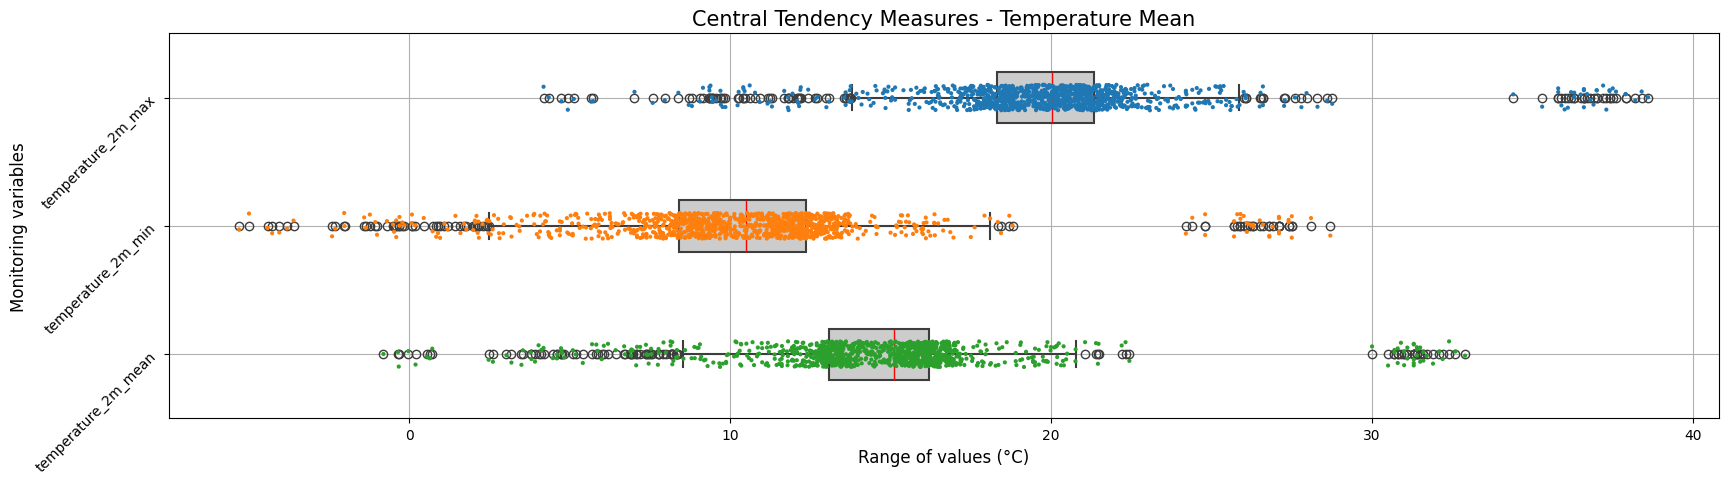

In [52]:
generate_bsplot(
    dataTable=_data[['temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean']],
    title="Central Tendency Measures - Temperature Mean",
    xlabel="°C"
    )

> Apparent Temperature

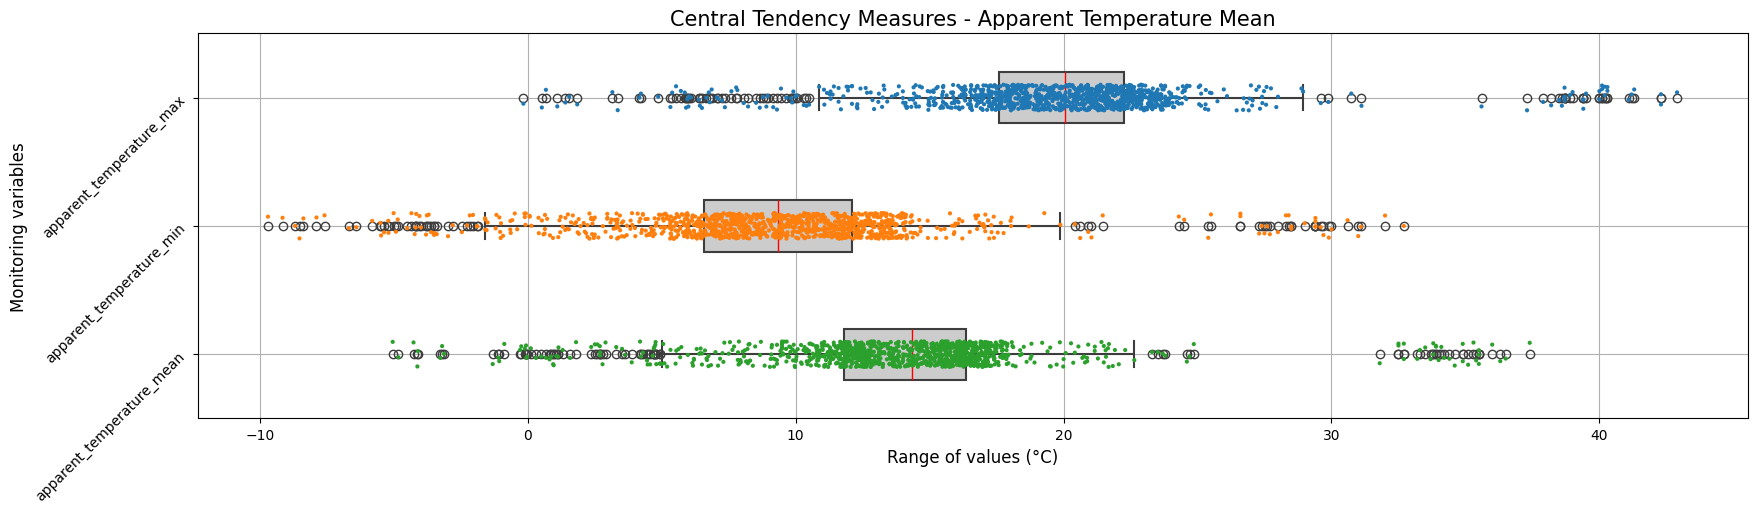

In [53]:
generate_bsplot(
    dataTable=_data[['apparent_temperature_max', 'apparent_temperature_min', 'apparent_temperature_mean']],
    title="Central Tendency Measures - Apparent Temperature Mean",
    xlabel="°C"
    )

> Precipitation and rain

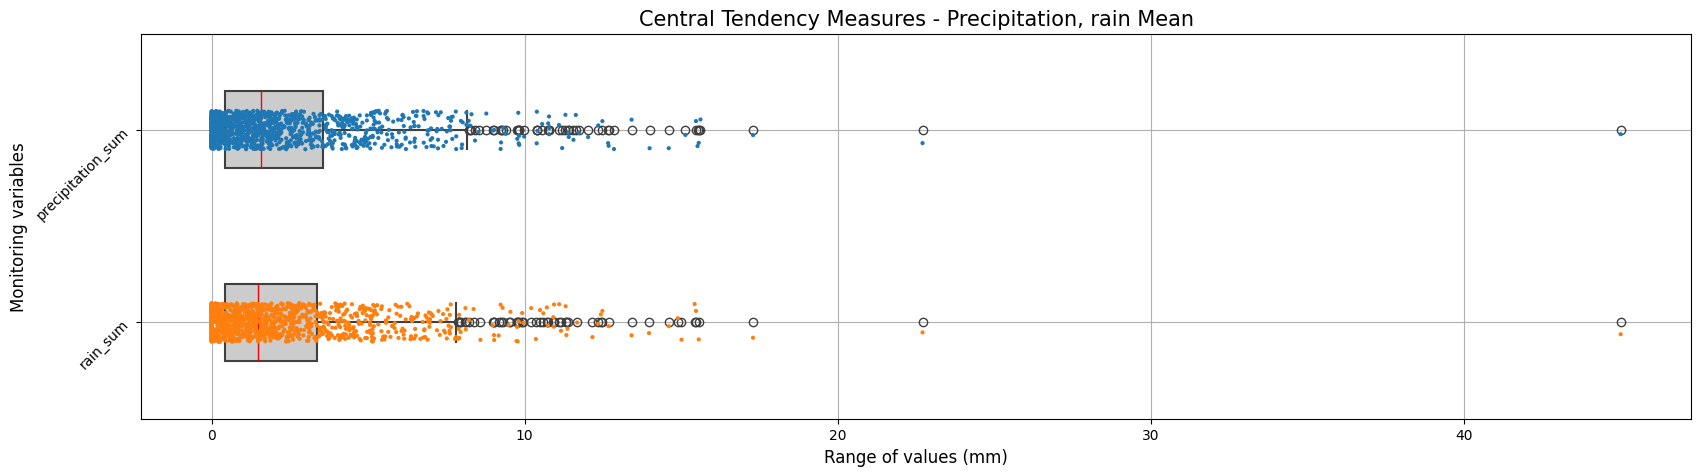

In [54]:
generate_bsplot(
    dataTable=_data[['precipitation_sum', 'rain_sum']],
    title="Central Tendency Measures - Precipitation, rain Mean",
    xlabel="mm"
    )

> Snowfall

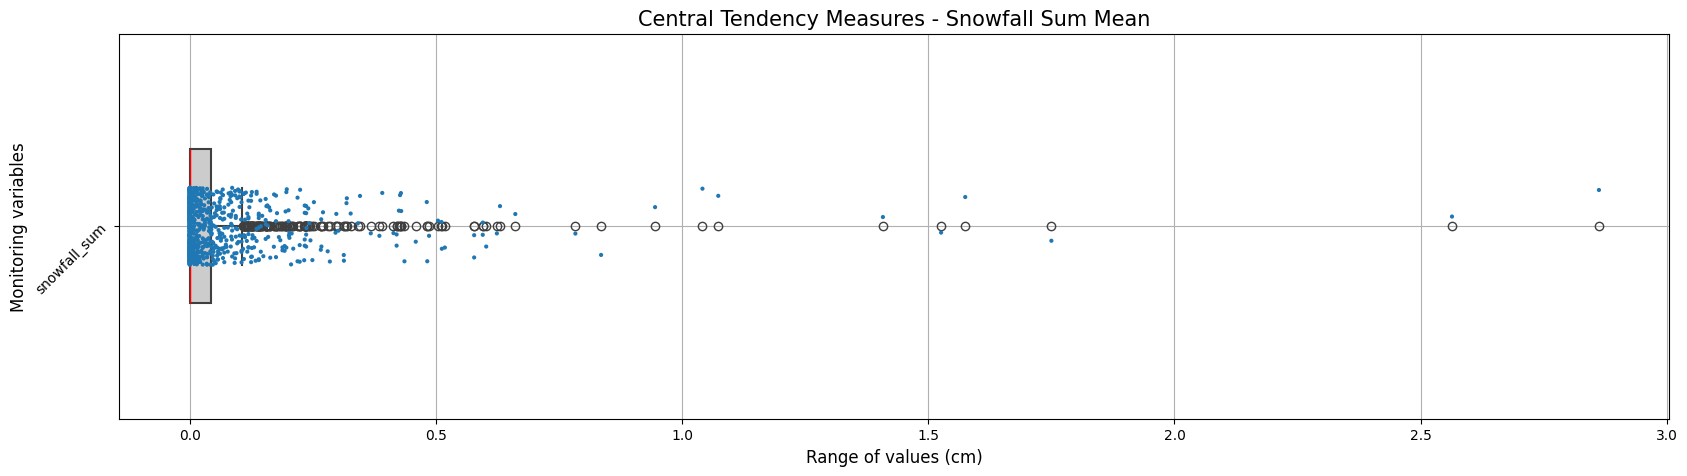

In [55]:
generate_bsplot(
    dataTable=_data[['snowfall_sum']],
    title="Central Tendency Measures - Snowfall Sum Mean",
    xlabel="cm"
    )

> Precipitation (h)

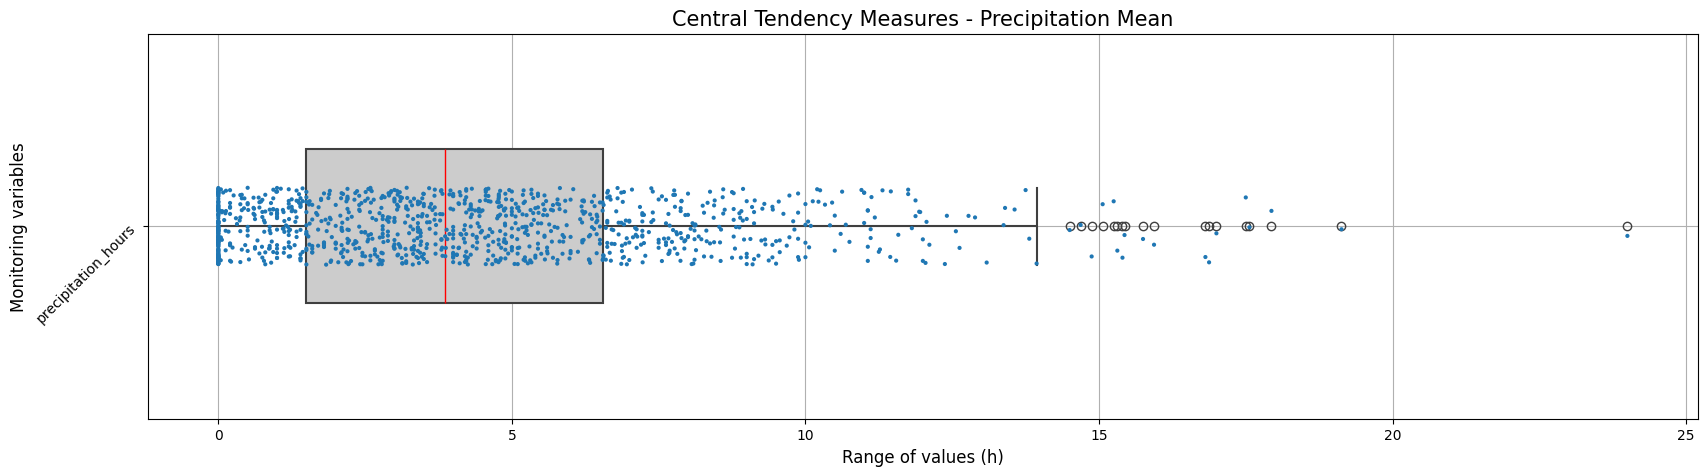

In [56]:
generate_bsplot(
    dataTable=_data[['precipitation_hours']],
    title="Central Tendency Measures - Precipitation Mean",
    xlabel="h"
    )

> Wind speed 10m

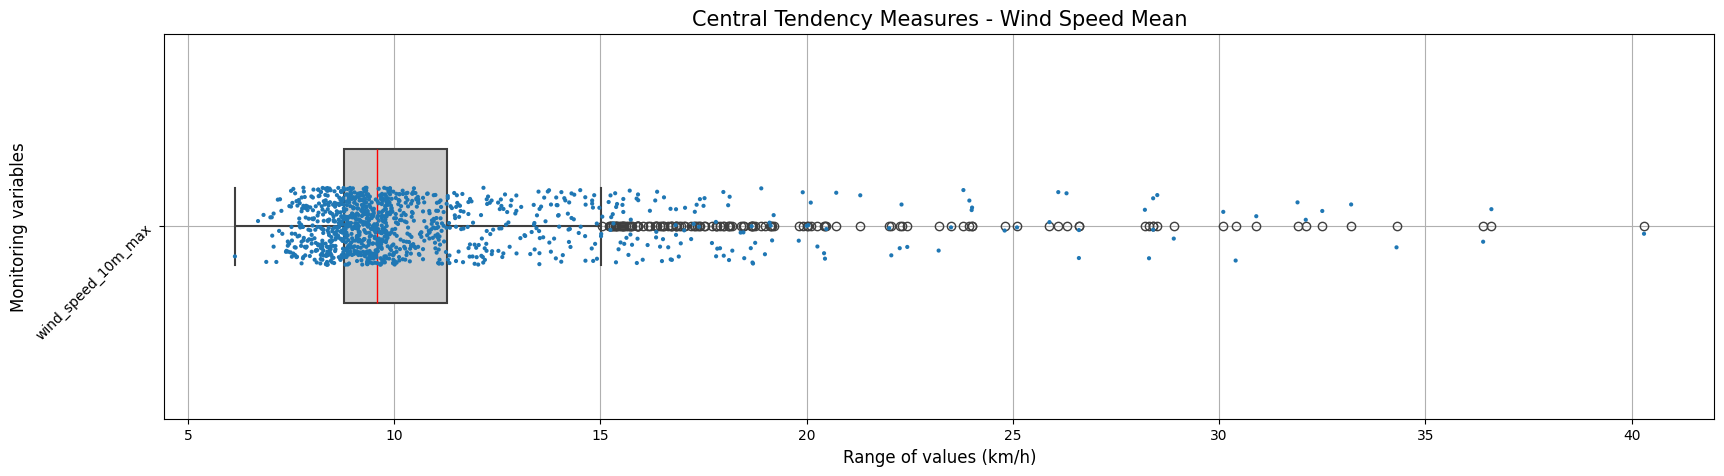

In [57]:
generate_bsplot(
    dataTable=_data[['wind_speed_10m_max']],
    title="Central Tendency Measures - Wind Speed Mean",
    xlabel="km/h"
    )

> Wind direction 10m

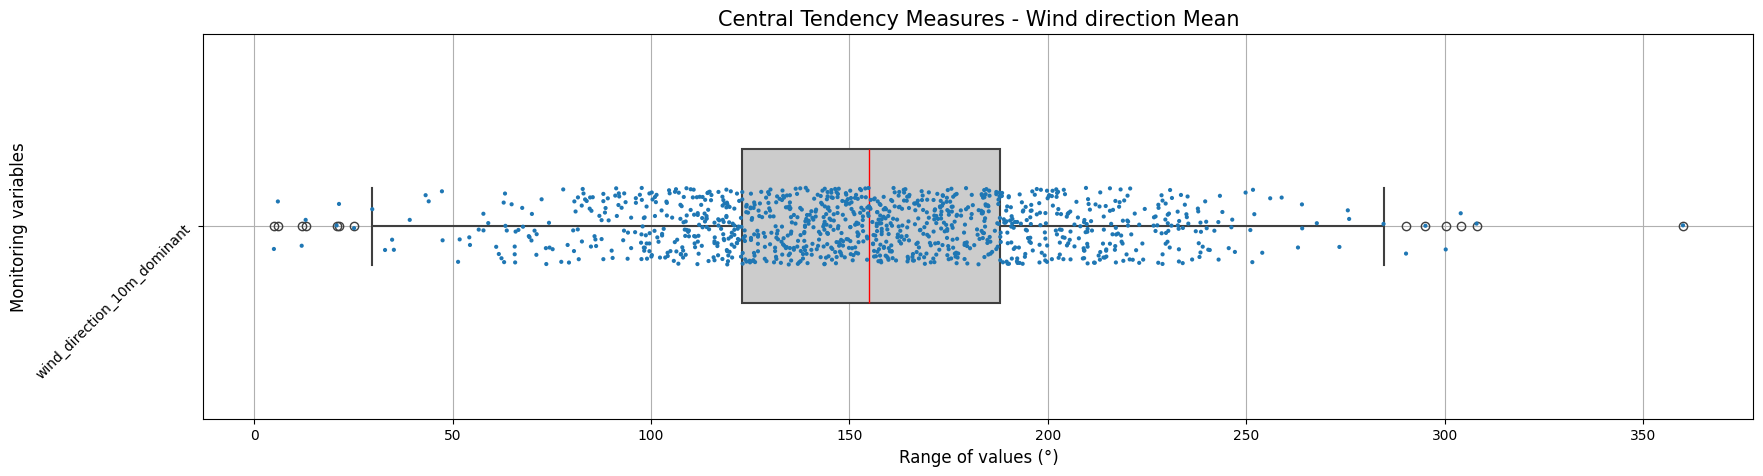

In [58]:
generate_bsplot(
    dataTable=_data[['wind_direction_10m_dominant']],
    title="Central Tendency Measures - Wind direction Mean",
    xlabel="°"
    )

> Shortware radiation sum

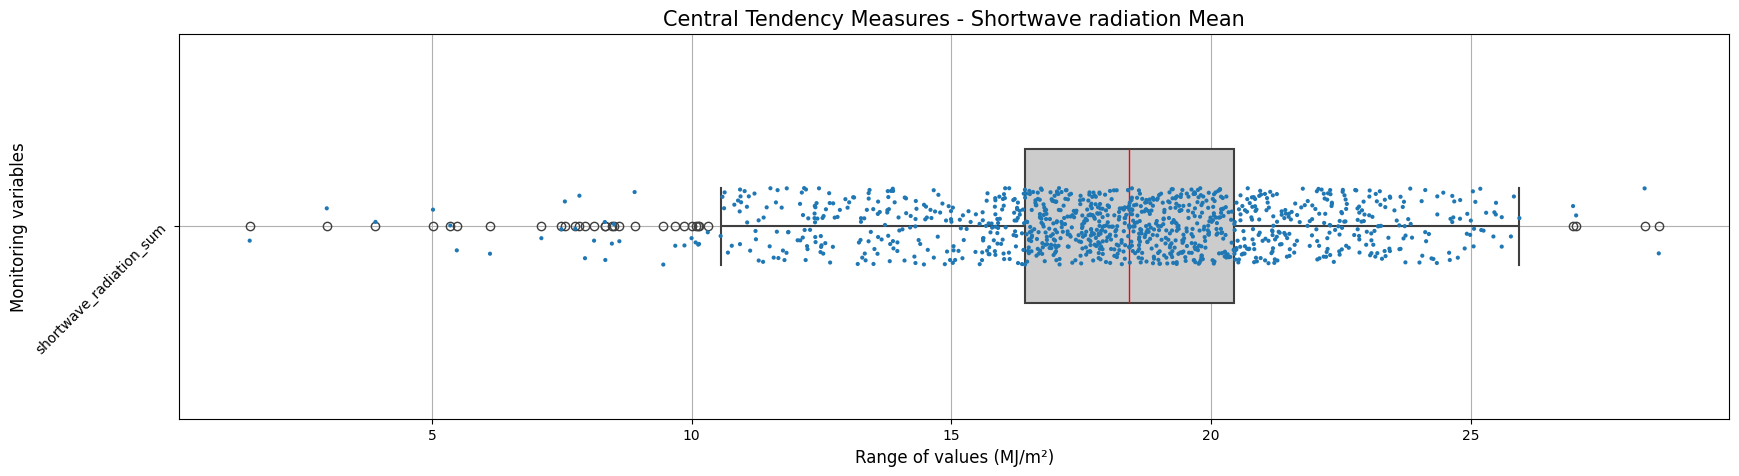

In [59]:
generate_bsplot(
    dataTable=_data[['shortwave_radiation_sum']],
    title="Central Tendency Measures - Shortwave radiation Mean",
    xlabel="MJ/m²"
    )

> Evapotranspiration

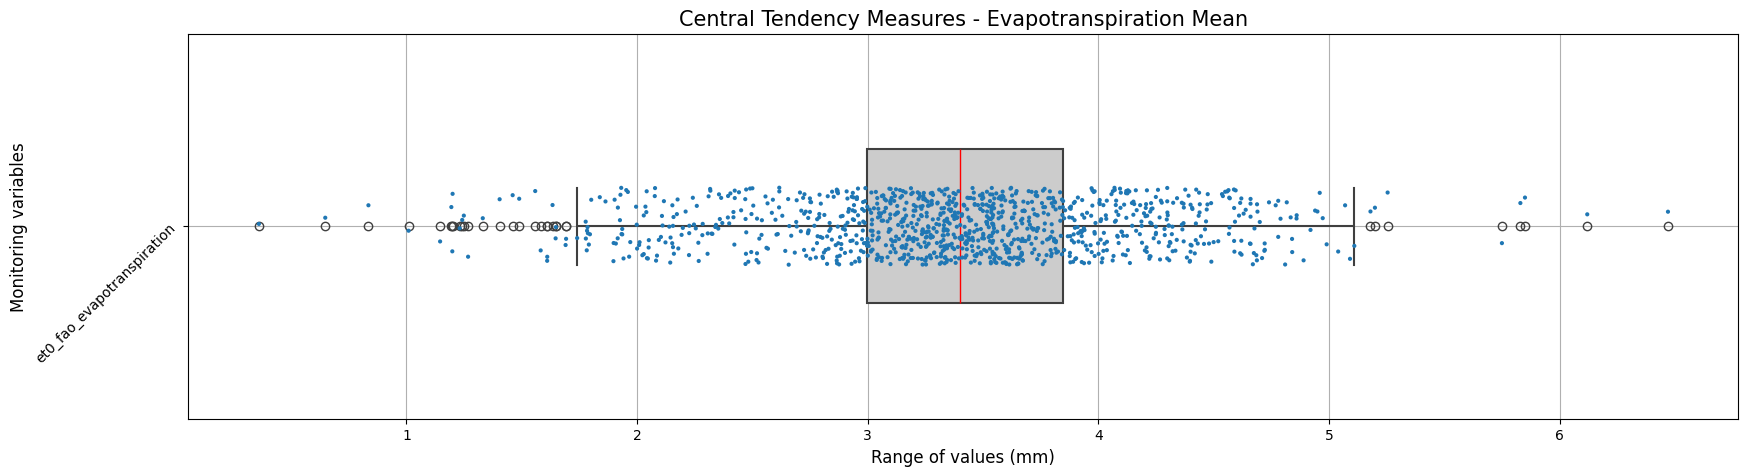

In [60]:
generate_bsplot(
    dataTable=_data[['et0_fao_evapotranspiration']],
    title="Central Tendency Measures - Evapotranspiration Mean",
    xlabel="mm"
    )

## Median

In [61]:
_data = df.groupby(['time']).median()
display(_data)

temperature_2m_max  temperature_2m_min  temperature_2m_mean  \
time                                                                      
2000-06-17                6.90               -1.10                 2.70   
2000-07-01               28.20               16.30                21.60   
2000-07-02               25.50               14.00                20.30   
2000-07-03               17.50                8.20                12.50   
2000-07-04               21.90                8.70                13.90   
...                        ...                 ...                  ...   
2015-09-26               19.45               12.00                15.20   
2015-09-27               20.45                9.40                15.45   
2015-09-28               20.30               10.40                15.40   
2015-09-29               20.50                9.30                14.65   
2015-09-30               19.35                9.55                14.30   

            apparent_temperature_max  apparent_temperature_min  \
time                                                             
2000-06-17                      3.35                     -5.00   
2000-07-01                     29.70                     15.90   
2000-07-02                     25.80                     11.50   
2000-07-03                     13.90                      5.10   
2000-07-04                     22.90                      5.80   
...                              ...                       ...   
2015-09-26                     18.75                     10.75   
2015-09-27                     20.00                      7.95   
2015-09-28                     20.55                      8.60   
2015-09-29                     19.70                      7.85   
2015-09-30                     20.00                      8.35   

            apparent_temperature_mean  precipitation_sum  rain_sum  \
time                                                                 
2000-06-17                      -0.95               0.00      0.00   
2000-07-01                      22.00               0.00      0.00   
2000-07-02                      19.00              18.90     18.90   
2000-07-03                       9.70               0.00      0.00   
2000-07-04                      12.40               0.00      0.00   
...                               ...                ...       ...   
2015-09-26                      14.00               3.30      2.90   
2015-09-27                      14.40               1.15      1.15   
2015-09-28                      13.70               1.80      1.80   
2015-09-29                      13.40               0.20      0.20   
2015-09-30                      13.65               1.10      1.00   

            snowfall_sum  precipitation_hours  wind_speed_10m_max  \
time                                                                
2000-06-17           0.0                  0.0               13.70   
2000-07-01           0.0                  0.0               23.60   
2000-07-02           0.0                  7.0               24.80   
2000-07-03           0.0                  0.0               17.50   
2000-07-04           0.0                  0.0               12.20   
...                  ...                  ...                 ...   
2015-09-26           0.0                  9.0               11.05   
2015-09-27           0.0                  3.5               10.35   
2015-09-28           0.0                  4.5               10.95   
2015-09-29           0.0                  1.5               12.20   
2015-09-30           0.0                  2.5               12.50   

            wind_gusts_10m_max  wind_direction_10m_dominant  \
time                                                          
2000-06-17               25.00                        161.5   
2000-07-01               45.40                         33.0   
2000-07-02               62.30                        307.0   
2000-07-03               37.10                       

### Data visualization with processing

> Temperature

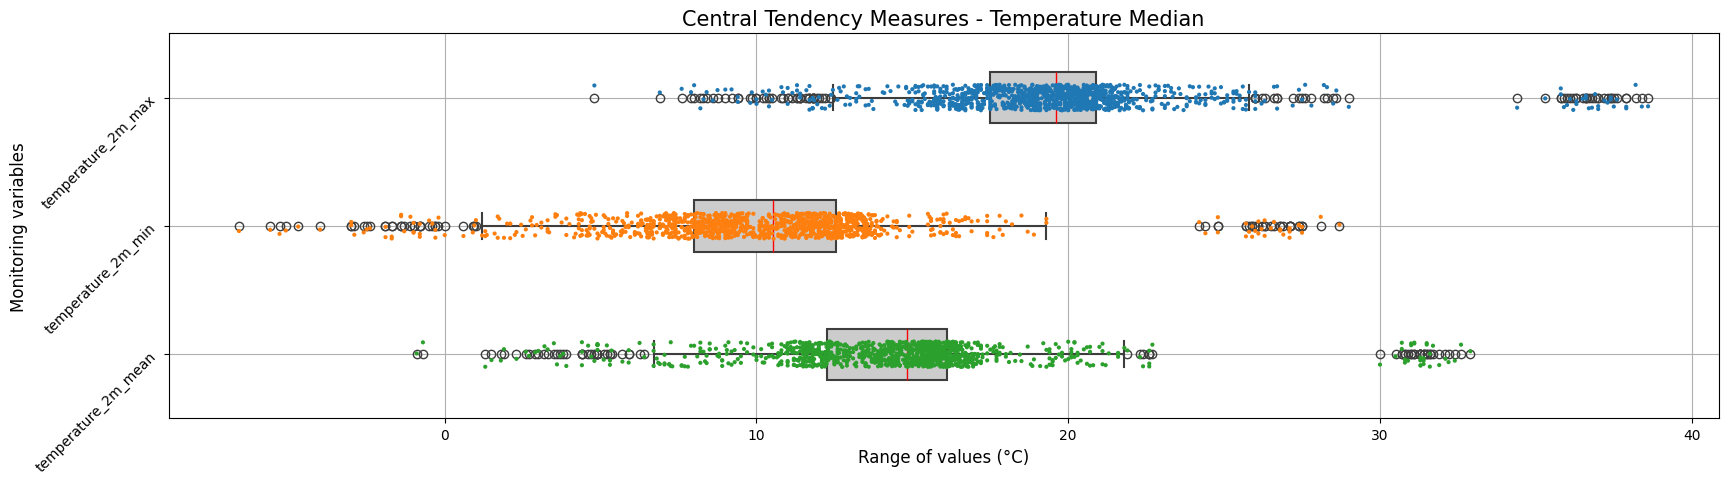

In [62]:
generate_bsplot(
    dataTable=_data[['temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean']],
    title="Central Tendency Measures - Temperature Median",
    xlabel="°C"
    )

> Apparent Temperature

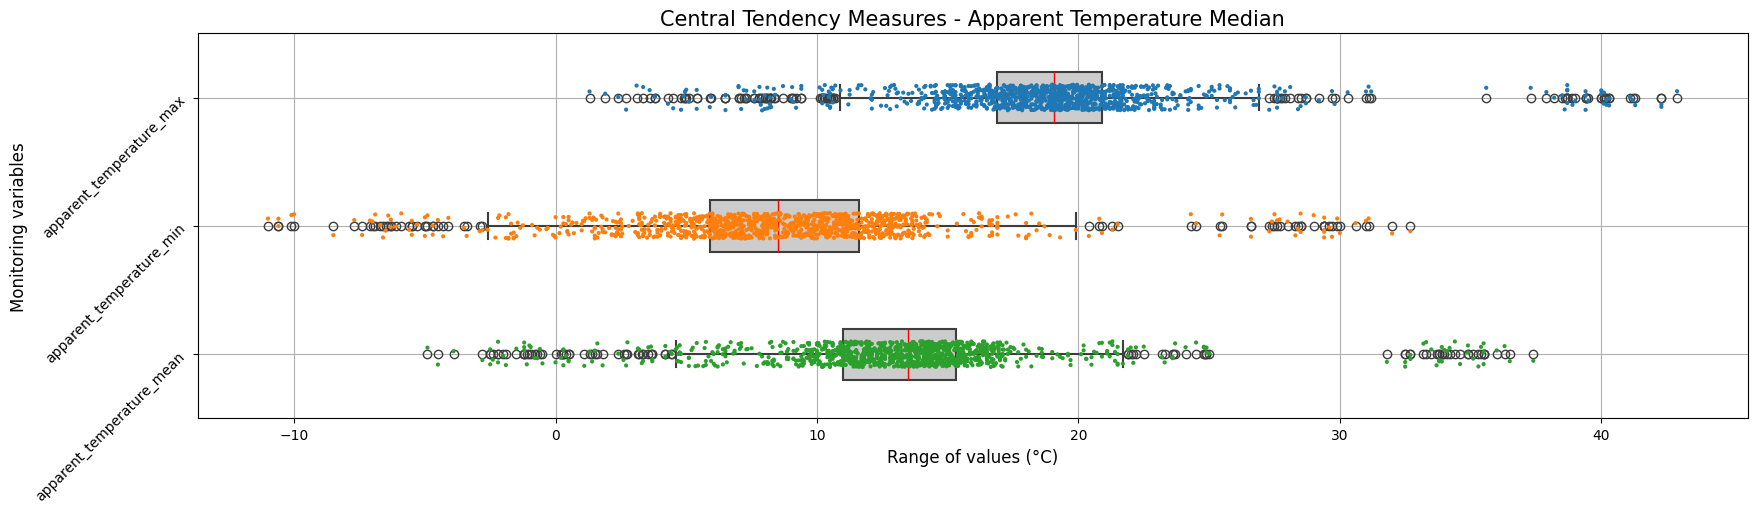

In [63]:
generate_bsplot(
    dataTable=_data[['apparent_temperature_max', 'apparent_temperature_min', 'apparent_temperature_mean']],
    title="Central Tendency Measures - Apparent Temperature Median",
    xlabel="°C"
    )

> Precipitation and rain

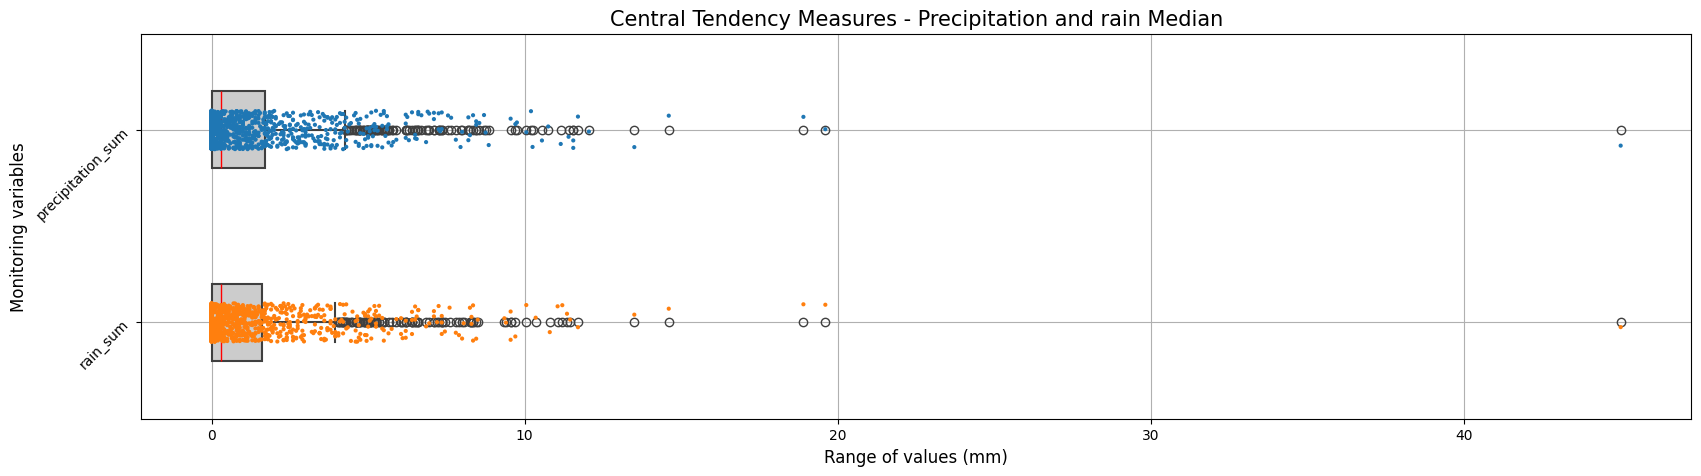

In [64]:
generate_bsplot(
    dataTable=_data[['precipitation_sum', 'rain_sum']],
    title="Central Tendency Measures - Precipitation and rain Median",
    xlabel="mm"
    )

> Snowfall

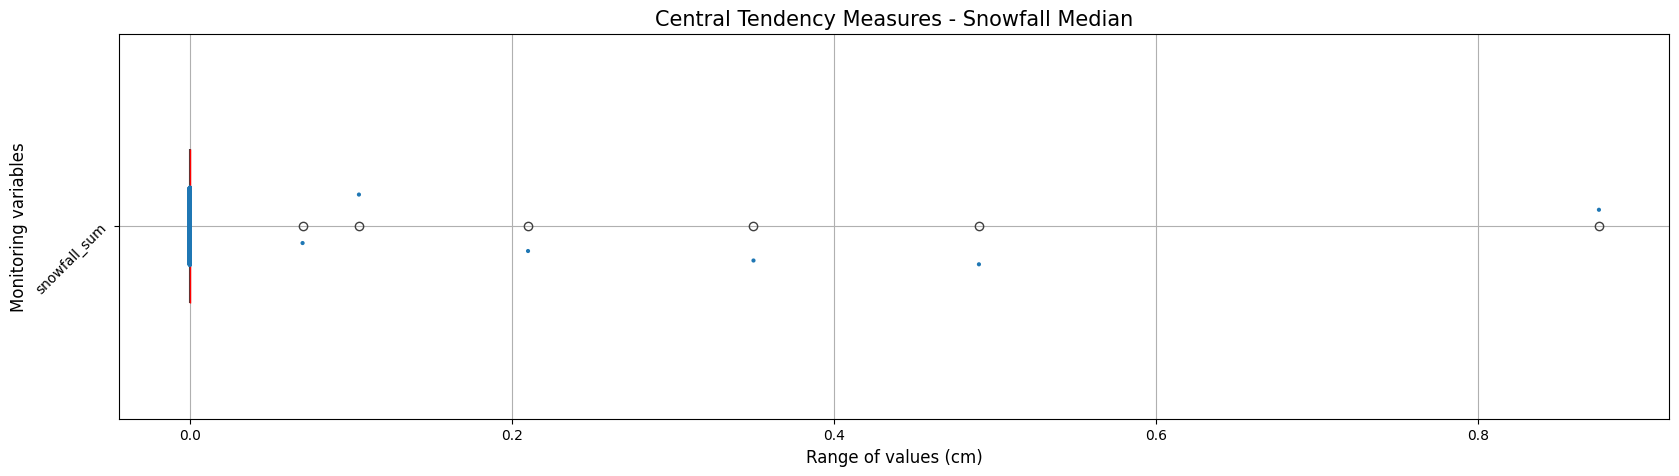

In [65]:
generate_bsplot(
    dataTable=_data[['snowfall_sum']],
    title="Central Tendency Measures - Snowfall Median",
    xlabel="cm"
    )

> Precipitation (h)

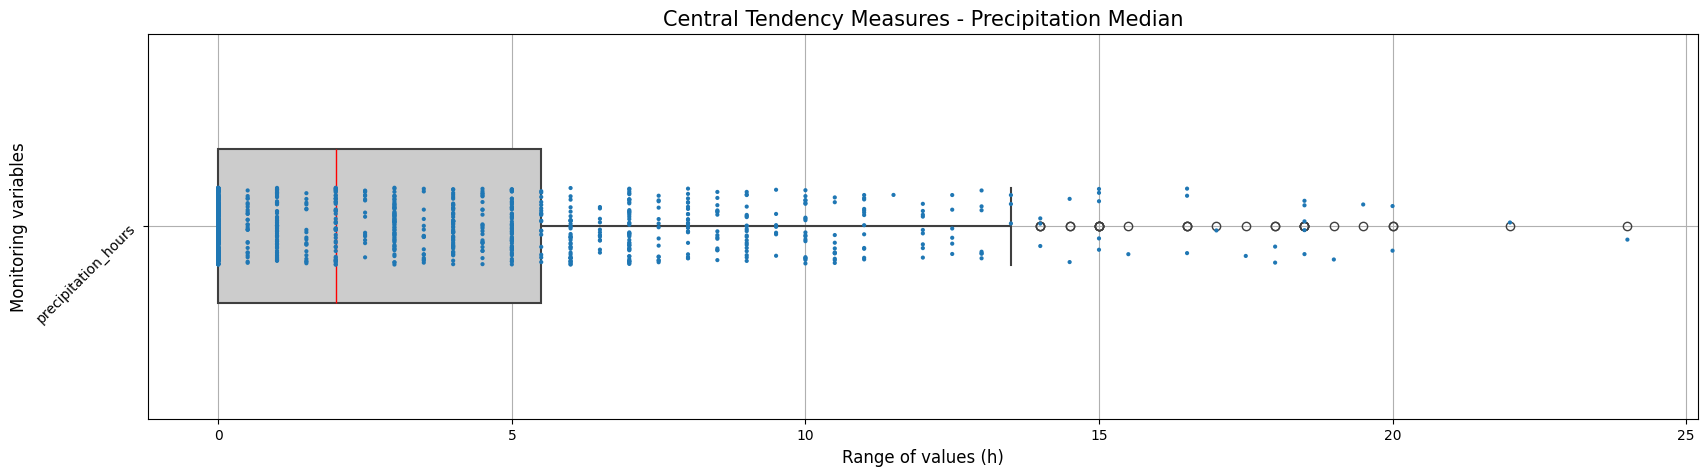

In [66]:
generate_bsplot(
    dataTable=_data[['precipitation_hours']],
    title="Central Tendency Measures - Precipitation Median",
    xlabel="h"
    )

> Wind speed 10m

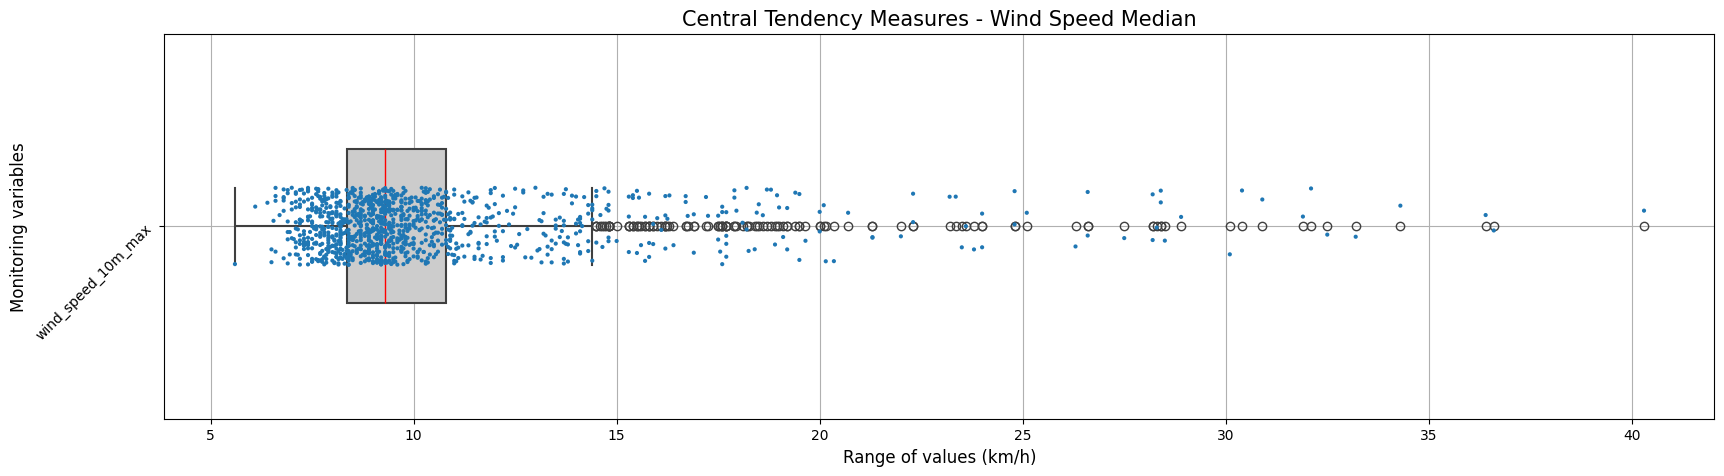

In [67]:
generate_bsplot(
    dataTable=_data[['wind_speed_10m_max']],
    title="Central Tendency Measures - Wind Speed Median",
    xlabel="km/h"
    )

> Wind direction 10m

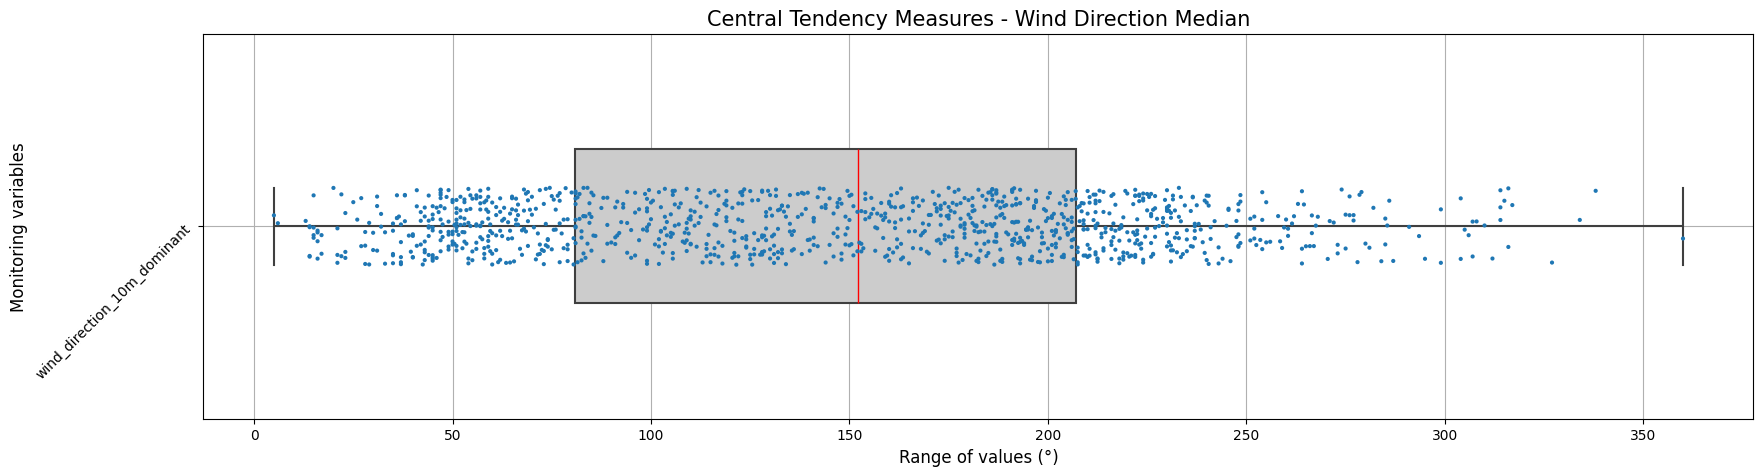

In [68]:
generate_bsplot(
    dataTable=_data[['wind_direction_10m_dominant']],
    title="Central Tendency Measures - Wind Direction Median",
    xlabel="°"
    )

> Shortwave radiation sum

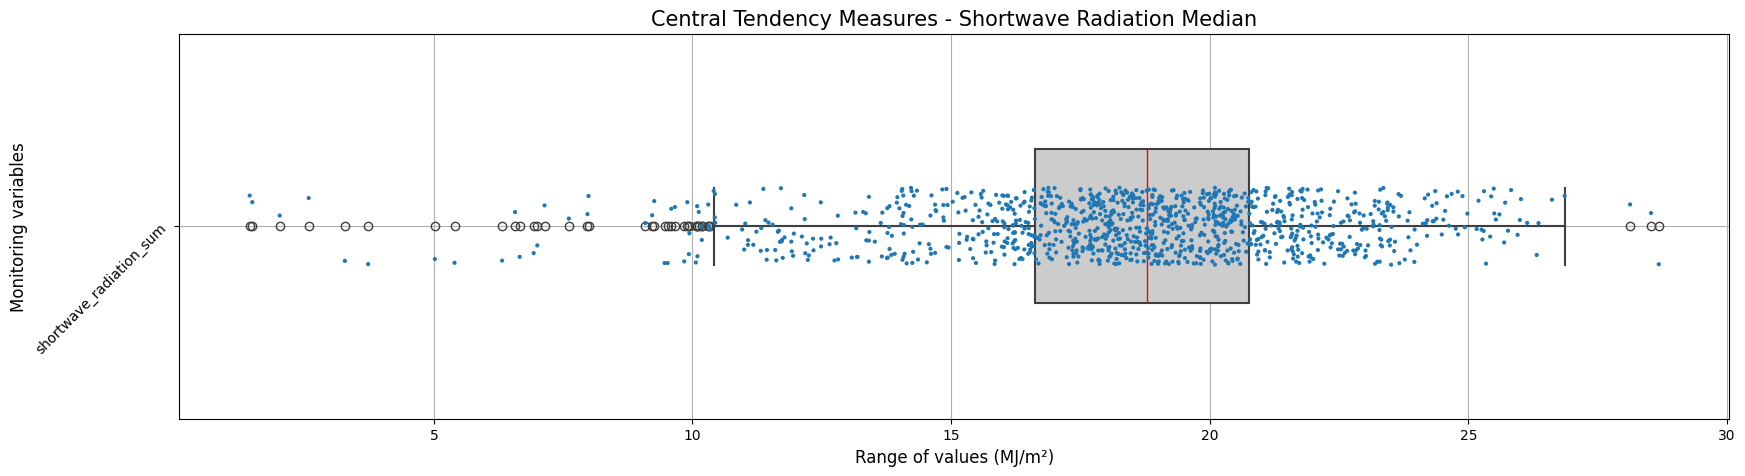

In [69]:
generate_bsplot(
    dataTable=_data[['shortwave_radiation_sum']],
    title="Central Tendency Measures - Shortwave Radiation Median",
    xlabel="MJ/m²"
    )

> Evapotranspiration

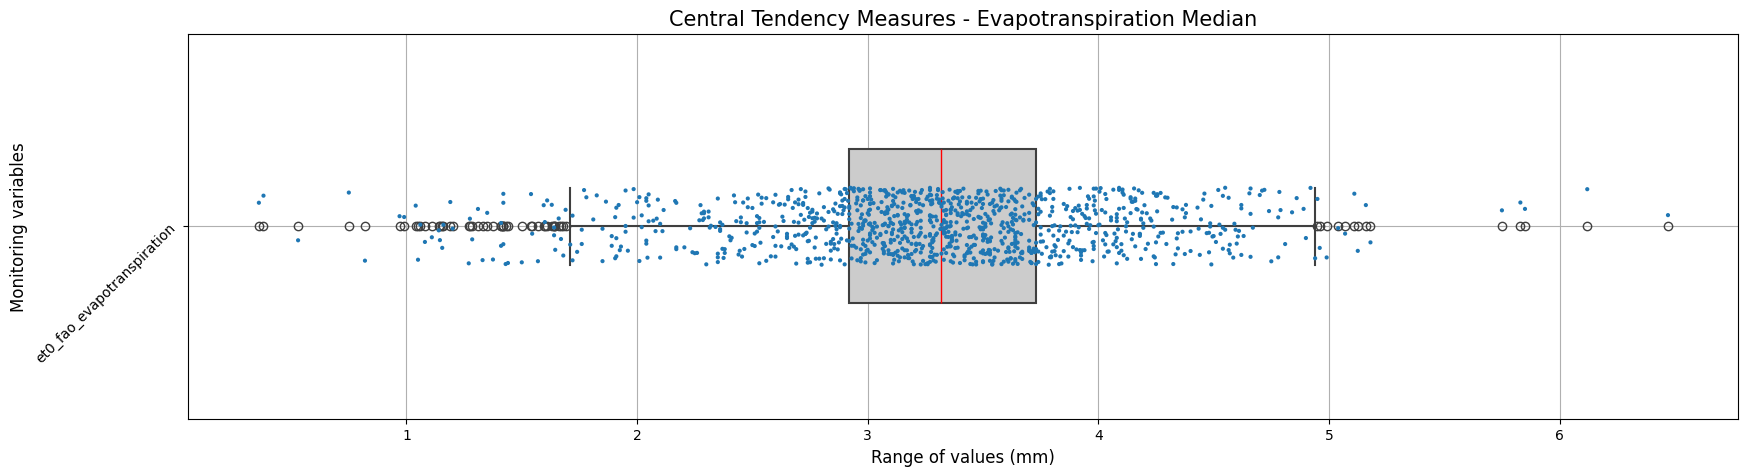

In [70]:
generate_bsplot(
    dataTable=_data[['et0_fao_evapotranspiration']],
    title="Central Tendency Measures - Evapotranspiration Median",
    xlabel="mm"
    )

# Data analysis - Dispersion Measures

## Variance

In [95]:
_data = df.groupby(['time']).var()
display(_data)

temperature_2m_max  temperature_2m_min  temperature_2m_mean  \
time                                                                      
2000-06-17           85.983333          128.500000           111.896667   
2000-07-01           28.962016           35.480672            27.397826   
2000-07-02           24.486957           15.231304            19.563399   
2000-07-03           18.007828           15.086925            12.205828   
2000-07-04           12.102569           16.302609            11.569526   
...                        ...                 ...                  ...   
2015-09-26           70.894333           71.826667            71.071222   
2015-09-27           66.745000           75.999556            67.796556   
2015-09-28           78.029889           58.453444            66.444444   
2015-09-29           68.814333           66.782222            64.516111   
2015-09-30           66.723222           73.596000            66.424556   

            apparent_temperature_max  apparent_temperature_min  \
time                                                             
2000-06-17                 99.555833                145.720000   
2000-07-01                 34.639921                 52.415296   
2000-07-02                 33.986917                 24.846917   
2000-07-03                 22.146946                 20.843183   
2000-07-04                 25.531779                 23.235889   
...                              ...                       ...   
2015-09-26                109.544889                 99.622333   
2015-09-27                 94.093444                100.460444   
2015-09-28                104.795556                 78.451111   
2015-09-29                 95.787111                 85.377889   
2015-09-30                 94.782667                 92.091222   

            apparent_temperature_mean  precipitation_sum    rain_sum  \
time                                                                   
2000-06-17                 127.166667           0.250000    0.250000   
2000-07-01                  38.716047           6.635375    6.635375   
2000-07-02                  31.708735          87.699012   87.699012   
2000-07-03                  17.571591         159.399806  157.657226   
2000-07-04                  19.733636           0.002095    0.002095   
...                               ...                ...         ...   
2015-09-26                 105.685000          28.336556   27.449000   
2015-09-27                  96.843222          42.453778   42.453778   
2015-09-28                  96.197333          18.682667   18.230667   
2015-09-29                  90.388889          15.975111   15.975111   
2015-09-30                  91.453444          37.862778   37.833444   

            snowfall_sum  precipitation_hours  wind_speed_10m_max  \
time                                                                
2000-06-17      0.000000             6.250000           15.256667   
2000-07-01      0.000000            20.383399           39.408024   
2000-07-02      0.000000             8.134387           71.737549   
2000-07-03      0.015806            49.378495           39.290903   
2000-07-04      0.000000             0.209486           22.999842   
...                  ...                  ...                 ...   
2015-09-26      0.079271            66.177778            5.850667   
2015-09-27      0.000000            54.444444            6.409889   
2015-09-28      0.017640            48.677778            4.604889   
2015-09-29      0.000000            29.566667            5.629000   
2015-09-30      0.041160            56.233333           10.066222   

            wind_gusts_10m_max  wind_direction_10m_dominant  \
time                                                          
2000-06-17           78.049167                  6660.666667   
2000-07-01           75.074822                 14855.059289   
2000-07-02          166.831660                 18232.055336   
2000-07-03          126.375

### Data visualization with processing

> Temperature

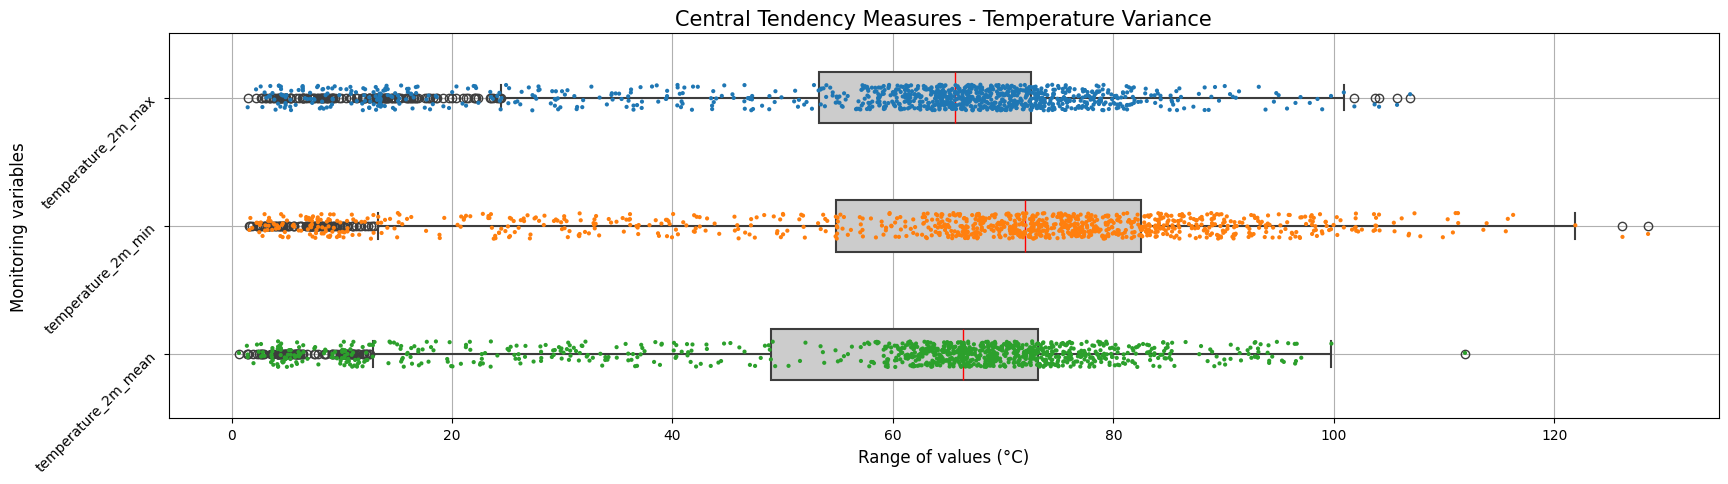

In [96]:
generate_bsplot(
    dataTable=_data[['temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean']],
    title="Central Tendency Measures - Temperature Variance",
    xlabel="°C"
    )

> Apparent Temperature

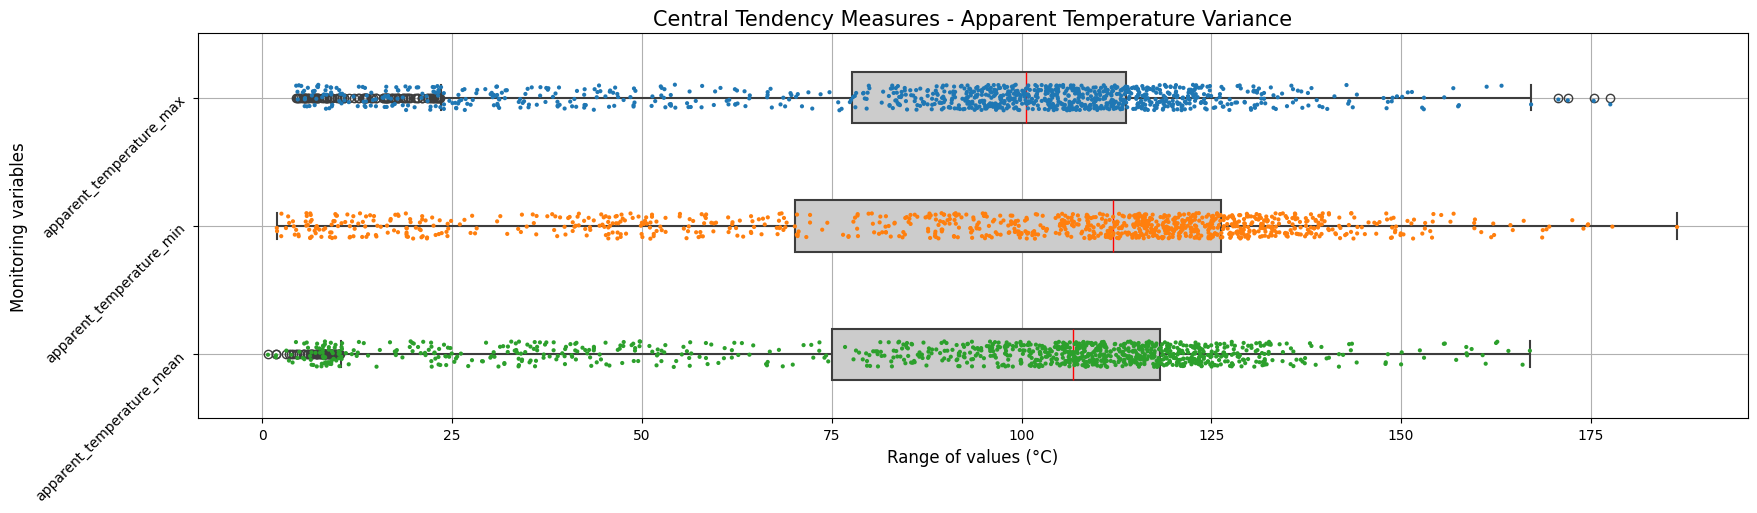

In [97]:
generate_bsplot(
    dataTable=_data[['apparent_temperature_max', 'apparent_temperature_min', 'apparent_temperature_mean']],
    title="Central Tendency Measures - Apparent Temperature Variance",
    xlabel="°C"
    )

> Precipitation and rain

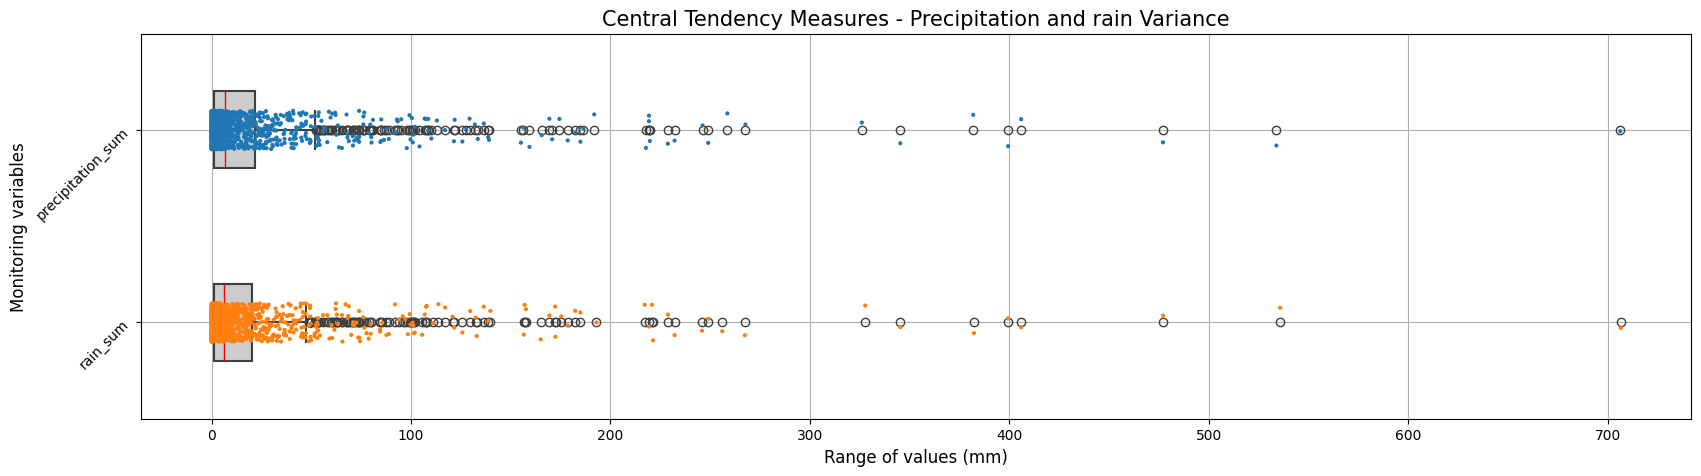

In [98]:
generate_bsplot(
    dataTable=_data[['precipitation_sum', 'rain_sum']],
    title="Central Tendency Measures - Precipitation and rain Variance",
    xlabel="mm"
    )

> Snowfall

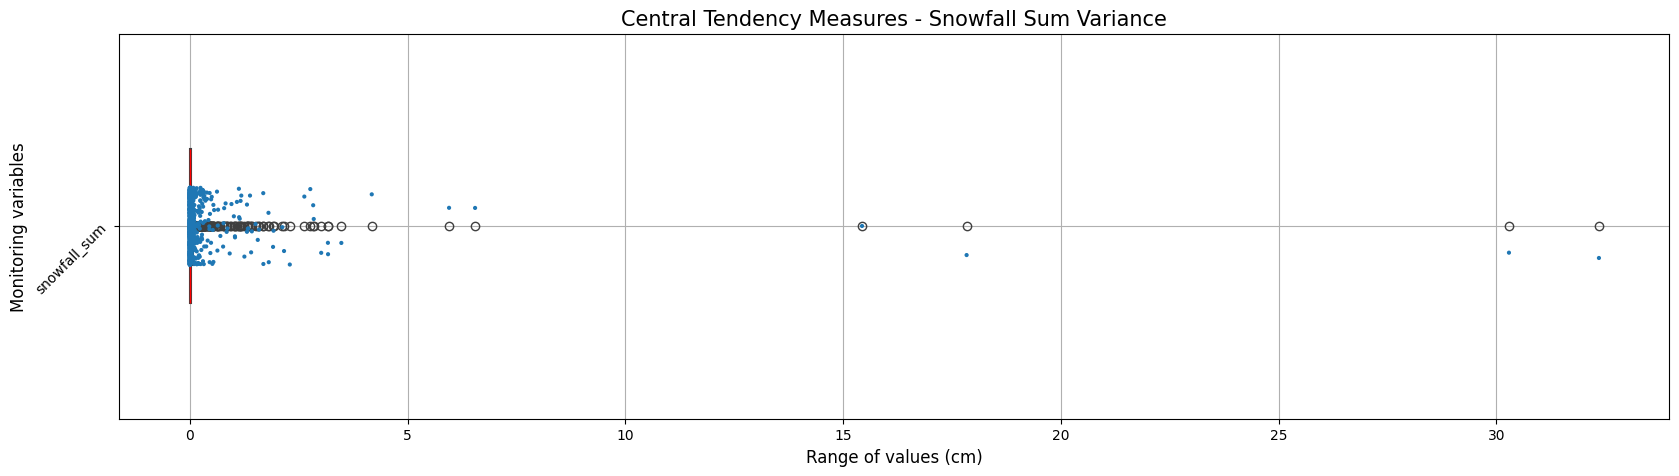

In [99]:
generate_bsplot(
    dataTable=_data[['snowfall_sum']],
    title="Central Tendency Measures - Snowfall Sum Variance",
    xlabel="cm"
    )

> Precipitation

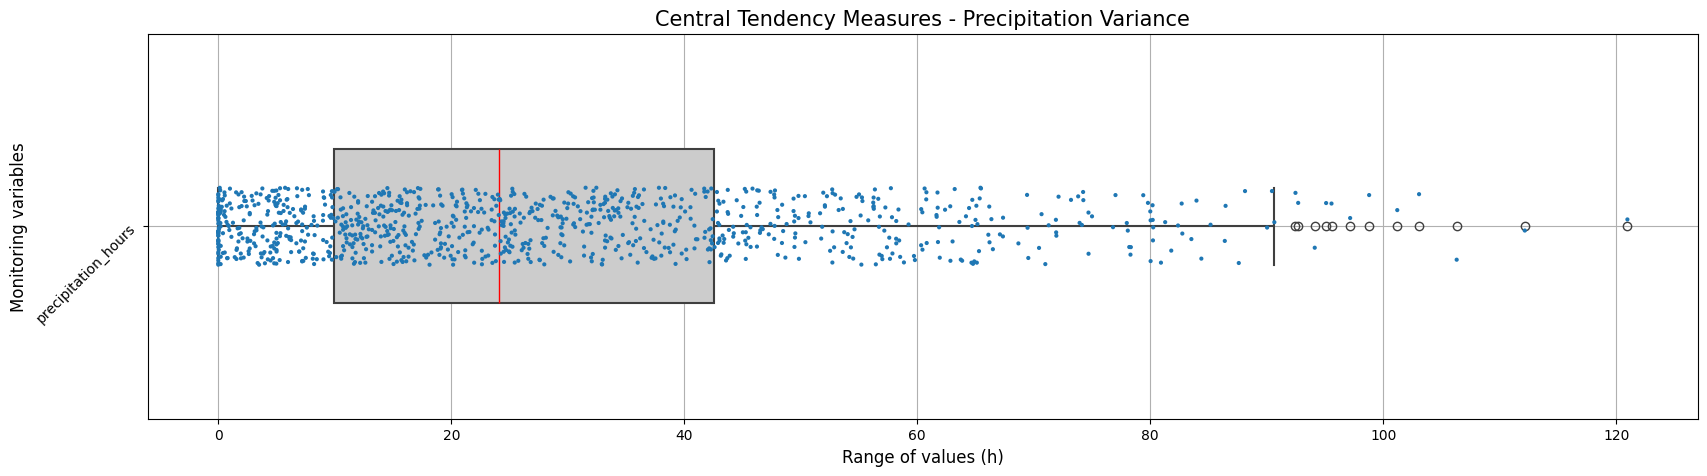

In [100]:
generate_bsplot(
    dataTable=_data[['precipitation_hours']],
    title="Central Tendency Measures - Precipitation Variance",
    xlabel="h"
    )

> Wind speed 10m

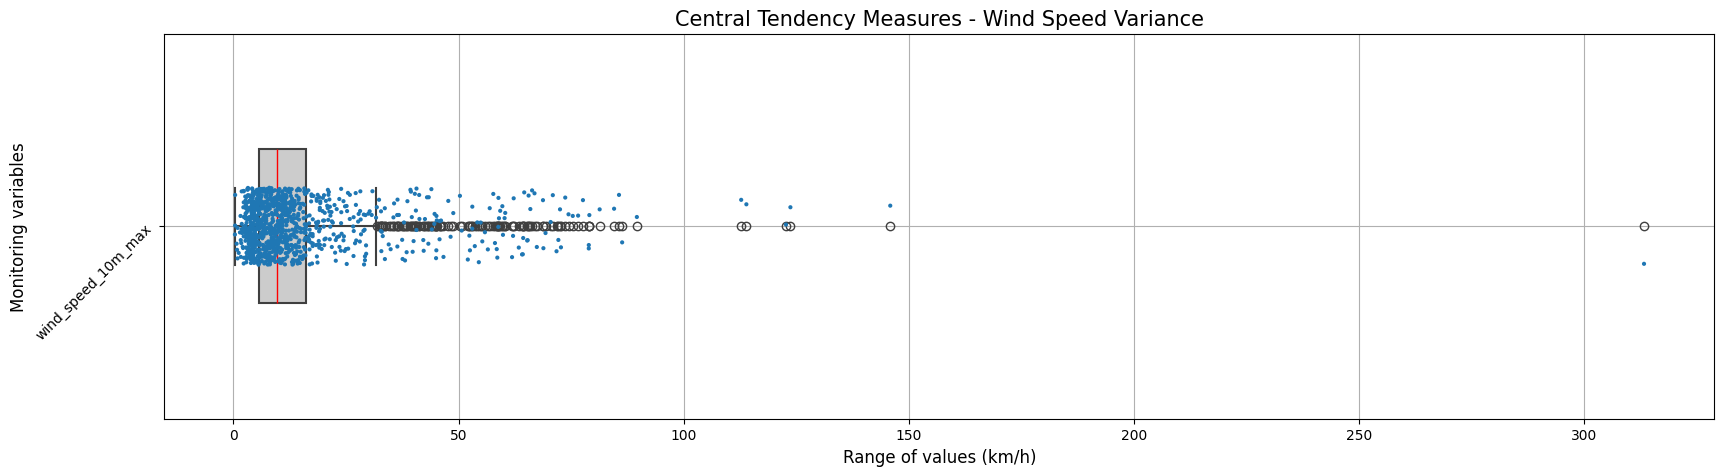

In [101]:
generate_bsplot(
    dataTable=_data[['wind_speed_10m_max']],
    title="Central Tendency Measures - Wind Speed Variance",
    xlabel="km/h"
    )

> Wind direction 10m

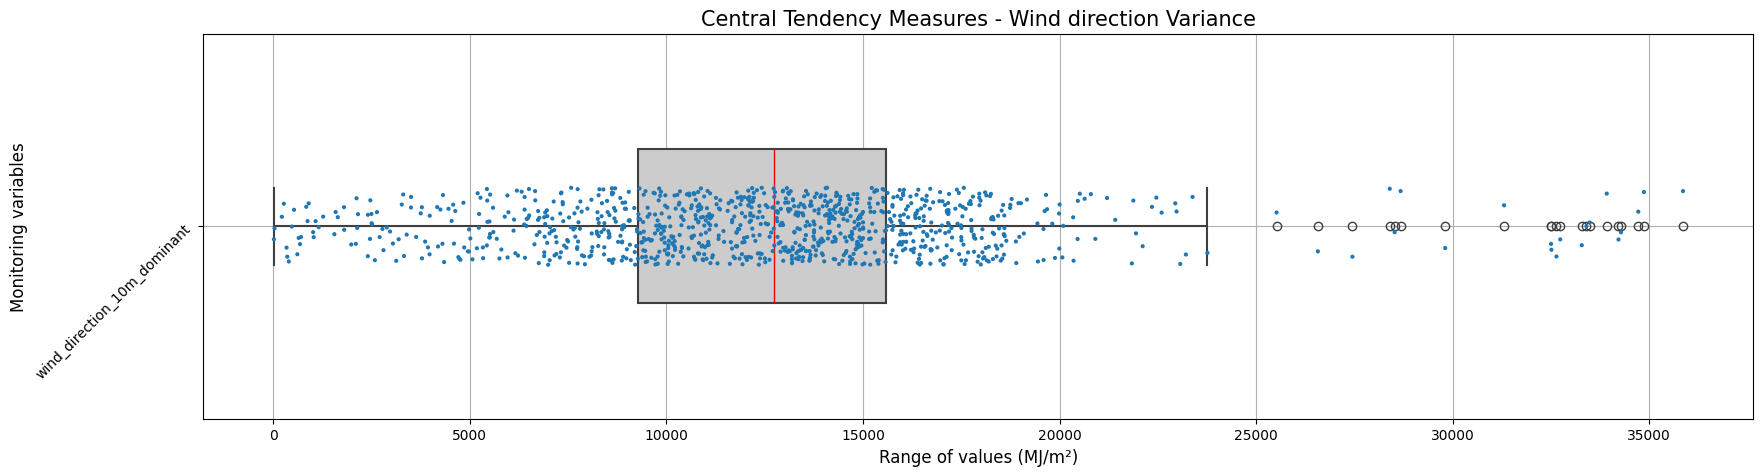

In [102]:
generate_bsplot(
    dataTable=_data[['wind_direction_10m_dominant']],
    title="Central Tendency Measures - Wind direction Variance",
    xlabel="MJ/m²"
    )

> Shortwave radiation

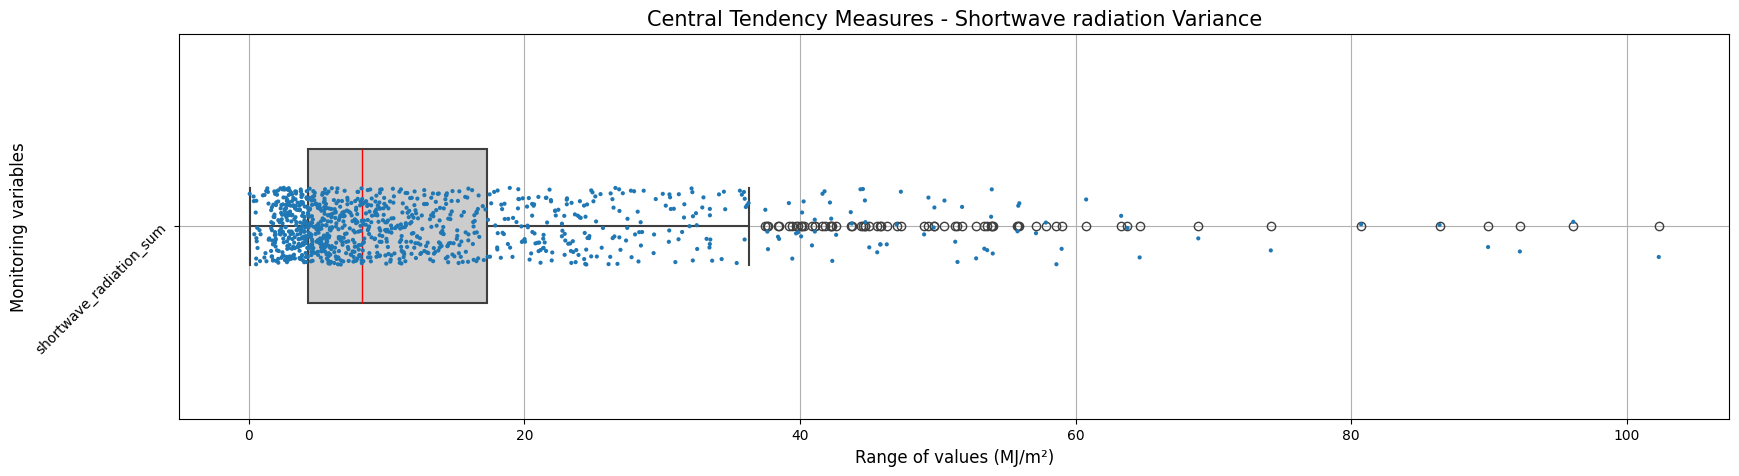

In [103]:
generate_bsplot(
    dataTable=_data[['shortwave_radiation_sum']],
    title="Central Tendency Measures - Shortwave radiation Variance",
    xlabel="MJ/m²"
    )

> Evapotranspiration

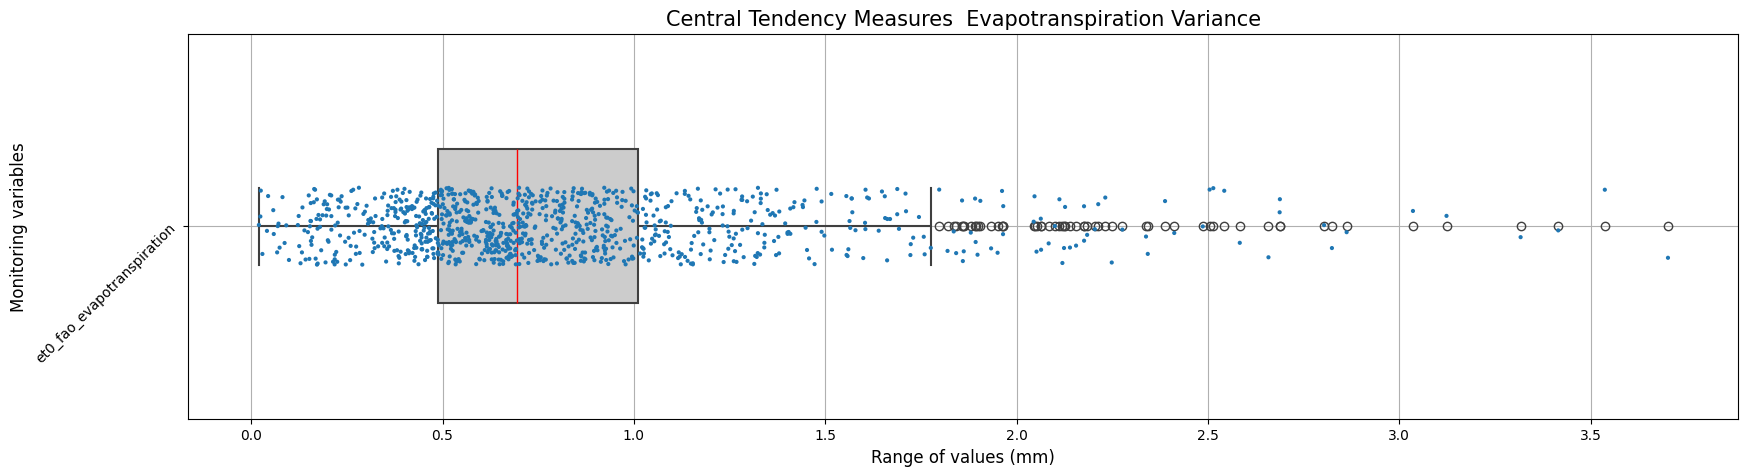

In [104]:
generate_bsplot(
    dataTable=_data[['et0_fao_evapotranspiration']],
    title="Central Tendency Measures  Evapotranspiration Variance",
    xlabel="mm"
    )

## Standard Deviation

In [105]:
_data = df.groupby(['time']).std(ddof=0)
display(_data)

temperature_2m_max  temperature_2m_min  temperature_2m_mean  \
time                                                                      
2000-06-17            8.030411            9.817077             9.160922   
2000-07-01            5.263345            5.825636             5.119240   
2000-07-02            4.839660            3.816946             4.325831   
2000-07-03            4.174557            3.821027             3.436872   
2000-07-04            3.402407            3.948899             3.326635   
...                        ...                 ...                  ...   
2015-09-26            7.987797            8.040149             7.997756   
2015-09-27            7.750516            8.270405             7.811332   
2015-09-28            8.380149            7.253144             7.733046   
2015-09-29            7.869746            7.752677             7.620007   
2015-09-30            7.749252            8.138575             7.731889   

            apparent_temperature_max  apparent_temperature_min  \
time                                                             
2000-06-17                  8.641000                 10.454186   
2000-07-01                  5.756200                  7.080704   
2000-07-02                  5.701686                  4.875102   
2000-07-03                  4.629528                  4.491194   
2000-07-04                  4.941832                  4.714407   
...                              ...                       ...   
2015-09-26                  9.929270                  9.468902   
2015-09-27                  9.202396                  9.508649   
2015-09-28                  9.711642                  8.402738   
2015-09-29                  9.284848                  8.765849   
2015-09-30                  9.236038                  9.103961   

            apparent_temperature_mean  precipitation_sum   rain_sum  \
time                                                                  
2000-06-17                   9.766012           0.433013   0.433013   
2000-07-01                   6.085453           2.519302   2.519302   
2000-07-02                   5.507277           9.158931   9.158931   
2000-07-03                   4.123684          12.420059  12.351984   
2000-07-04                   4.344612           0.044764   0.044764   
...                               ...                ...        ...   
2015-09-26                   9.752769           5.050040   4.970322   
2015-09-27                   9.335893           6.181294   6.181294   
2015-09-28                   9.304708           4.100537   4.050630   
2015-09-29                   9.019423           3.791781   3.791781   
2015-09-30                   9.072381           5.837508   5.835246   

            snowfall_sum  precipitation_hours  wind_speed_10m_max  \
time                                                                
2000-06-17      0.000000             2.165064            3.382676   
2000-07-01      0.000000             4.415559            6.139595   
2000-07-02      0.000000             2.789394            8.283630   
2000-07-03      0.123679             6.912716            6.166316   
2000-07-04      0.000000             0.447636            4.690400   
...                  ...                  ...                 ...   
2015-09-26      0.267103             7.717513            2.294690   
2015-09-27      0.000000             7.000000            2.401853   
2015-09-28      0.126000             6.618912            2.035780   
2015-09-29      0.000000             5.158488            2.250800   
2015-09-30      0.192468             7.114071            3.009917   

            wind_gusts_10m_max  wind_direction_10m_dominant  \
time                                                          
2000-06-17            7.650939                    70.678851   
2000-07-01            8.474119                   119.202295   
2000-07-02           12.632423                   132.058159   
2000-07-03           11.058862          

### Data visualization with processing

> Temperature

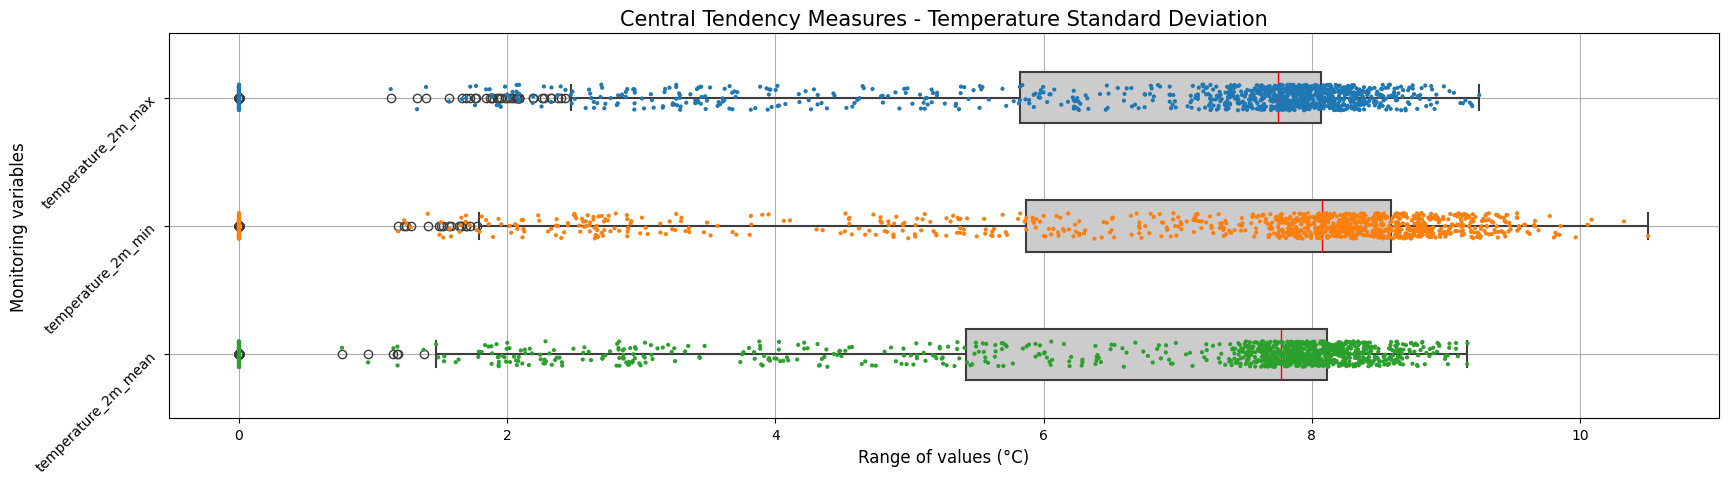

In [106]:
generate_bsplot(
    dataTable=_data[['temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean']],
    title="Central Tendency Measures - Temperature Standard Deviation",
    xlabel="°C"
    )

> Apparent Temperature

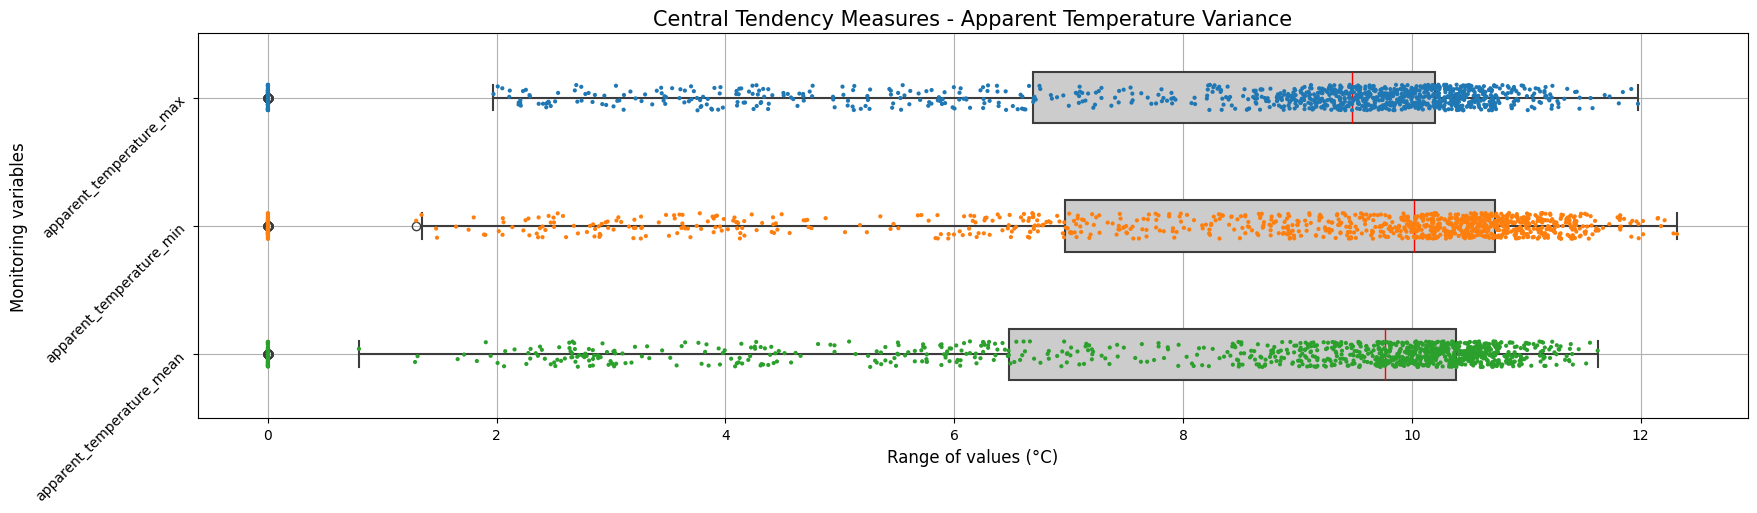

In [107]:
generate_bsplot(
    dataTable=_data[['apparent_temperature_max', 'apparent_temperature_min', 'apparent_temperature_mean']],
    title="Central Tendency Measures - Apparent Temperature Variance",
    xlabel="°C"
    )

> Precipitation and rain

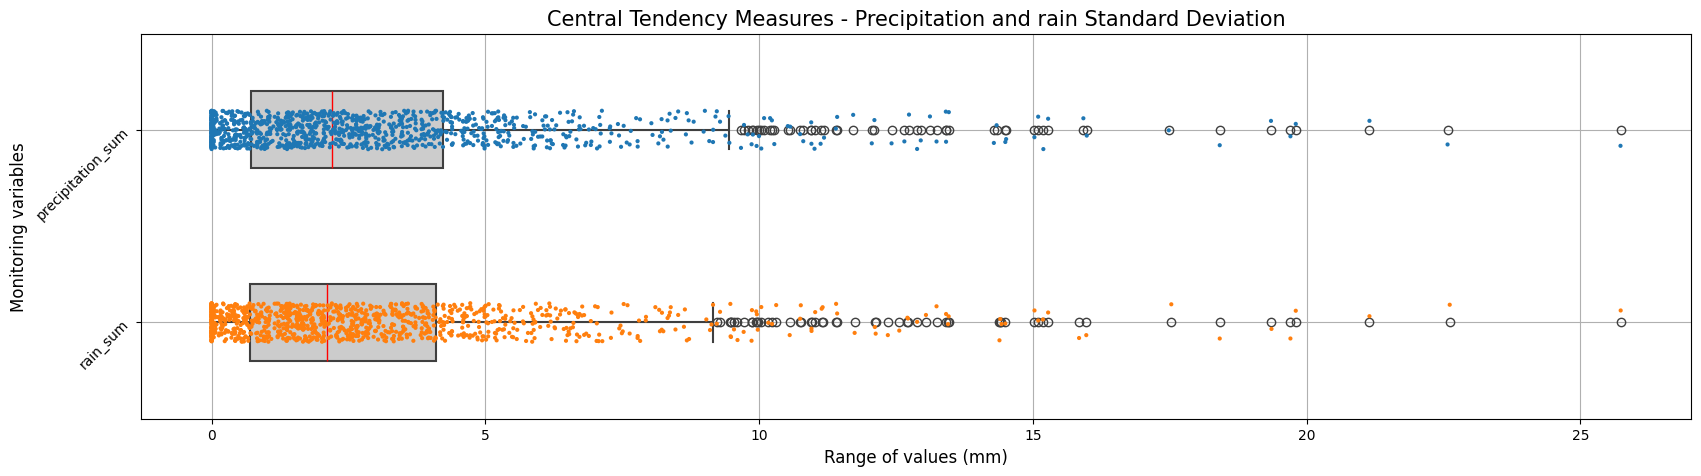

In [108]:
generate_bsplot(
    dataTable=_data[['precipitation_sum', 'rain_sum']],
    title="Central Tendency Measures - Precipitation and rain Standard Deviation",
    xlabel="mm"
    )

> Snowfall

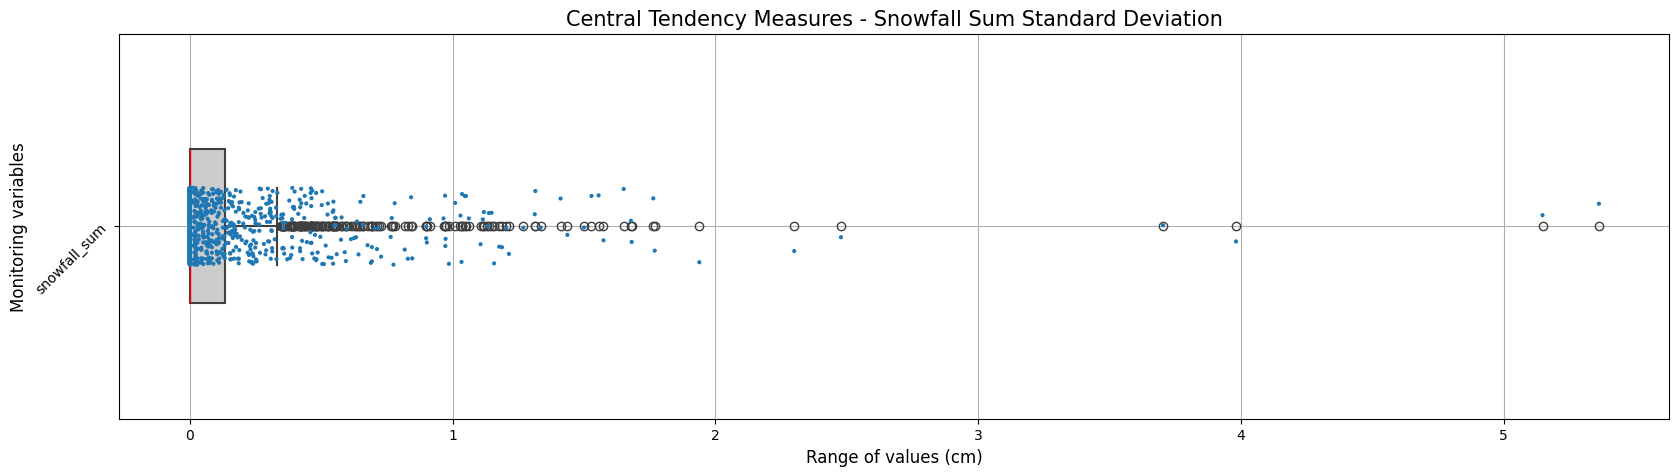

In [109]:
generate_bsplot(
    dataTable=_data[['snowfall_sum']],
    title="Central Tendency Measures - Snowfall Sum Standard Deviation",
    xlabel="cm"
    )

> Precipitation

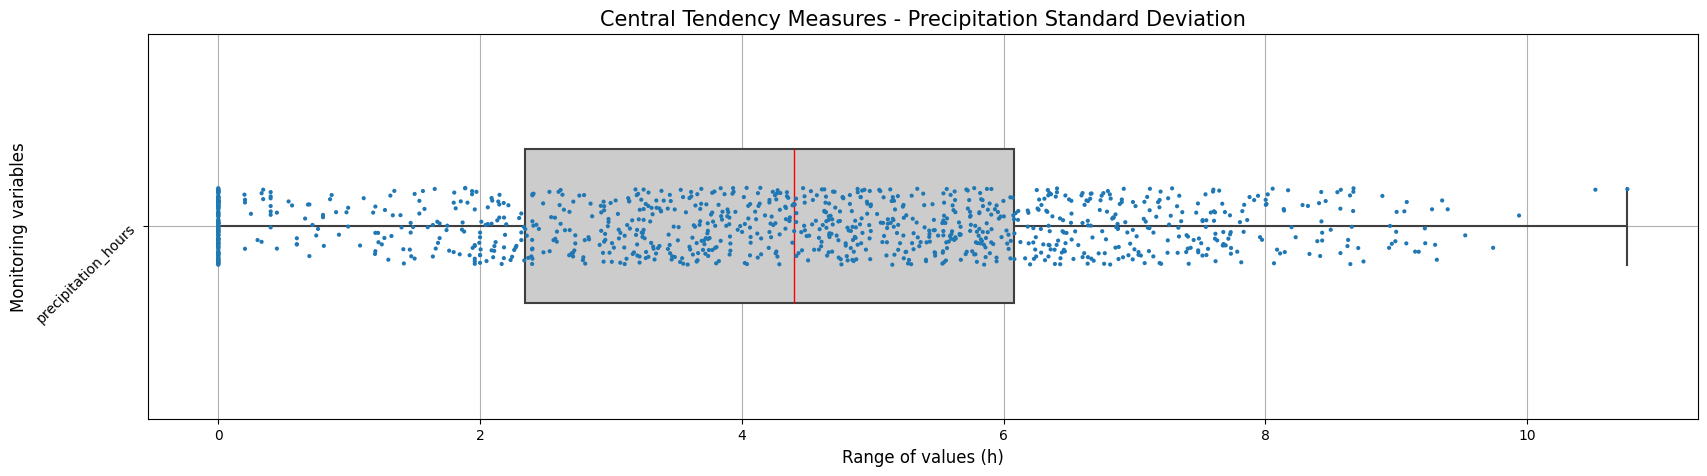

In [110]:
generate_bsplot(
    dataTable=_data[['precipitation_hours']],
    title="Central Tendency Measures - Precipitation Standard Deviation",
    xlabel="h"
    )

> Wind speed 10m

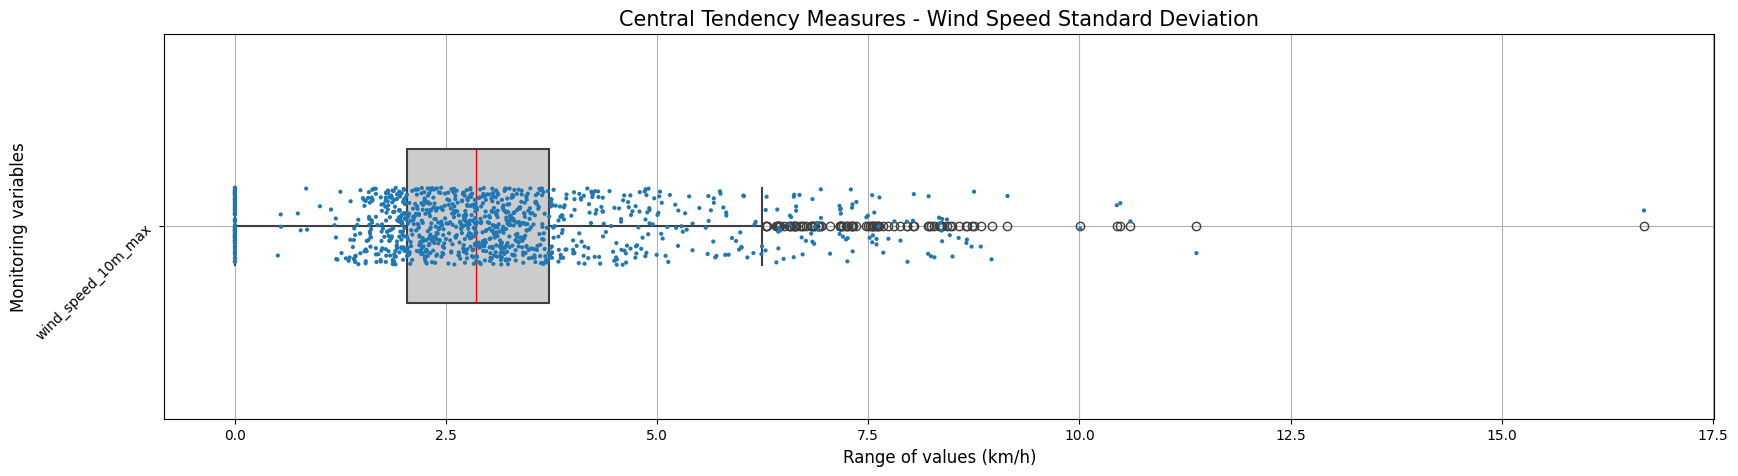

In [111]:
generate_bsplot(
    dataTable=_data[['wind_speed_10m_max']],
    title="Central Tendency Measures - Wind Speed Standard Deviation",
    xlabel="km/h"
    )

> Wind direction 10m

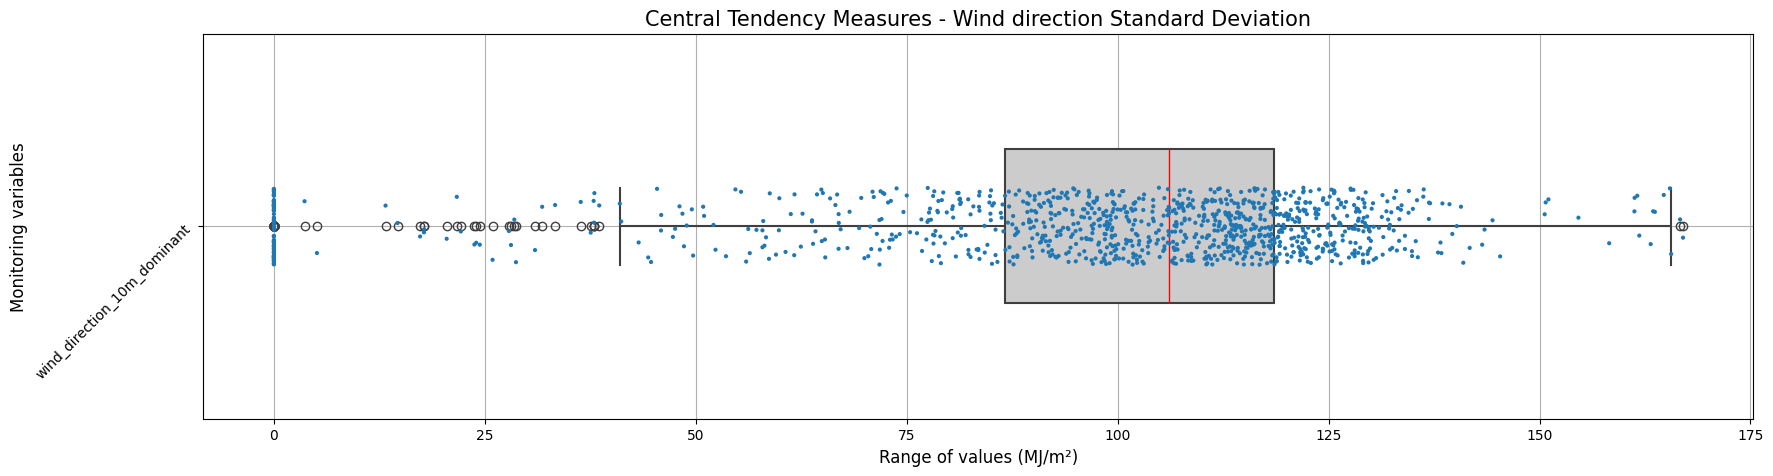

In [112]:
generate_bsplot(
    dataTable=_data[['wind_direction_10m_dominant']],
    title="Central Tendency Measures - Wind direction Standard Deviation",
    xlabel="MJ/m²"
    )

> Shortwave radiation

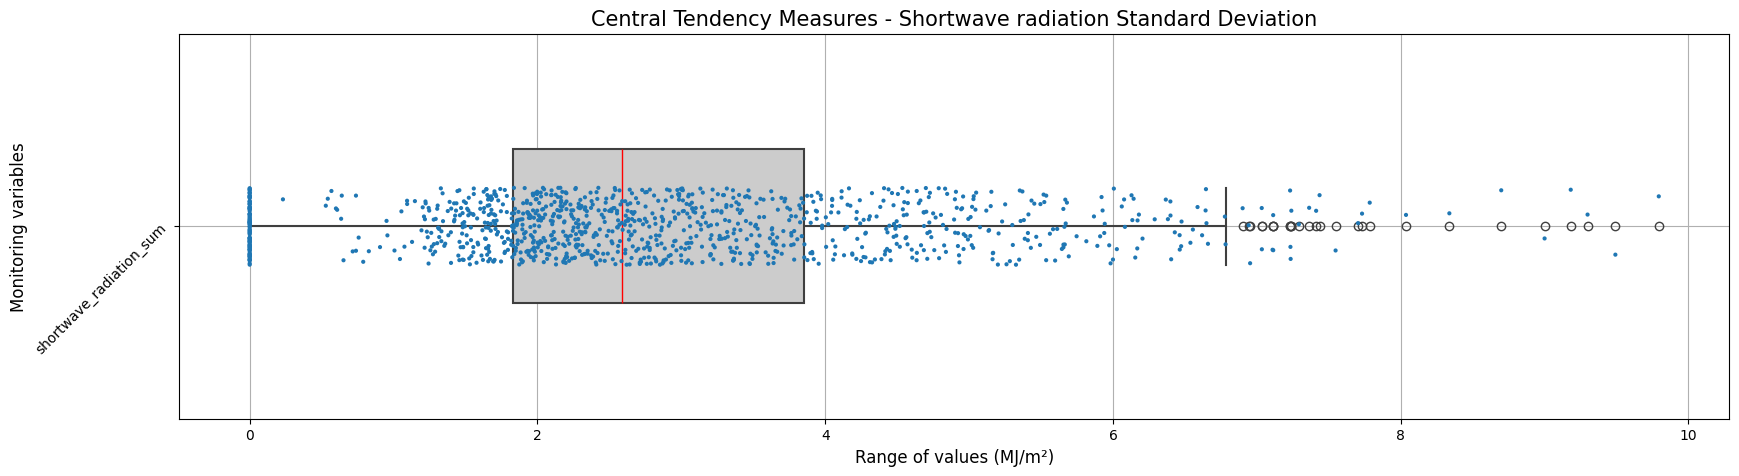

In [113]:
generate_bsplot(
    dataTable=_data[['shortwave_radiation_sum']],
    title="Central Tendency Measures - Shortwave radiation Standard Deviation",
    xlabel="MJ/m²"
    )

> Evapotranspiration

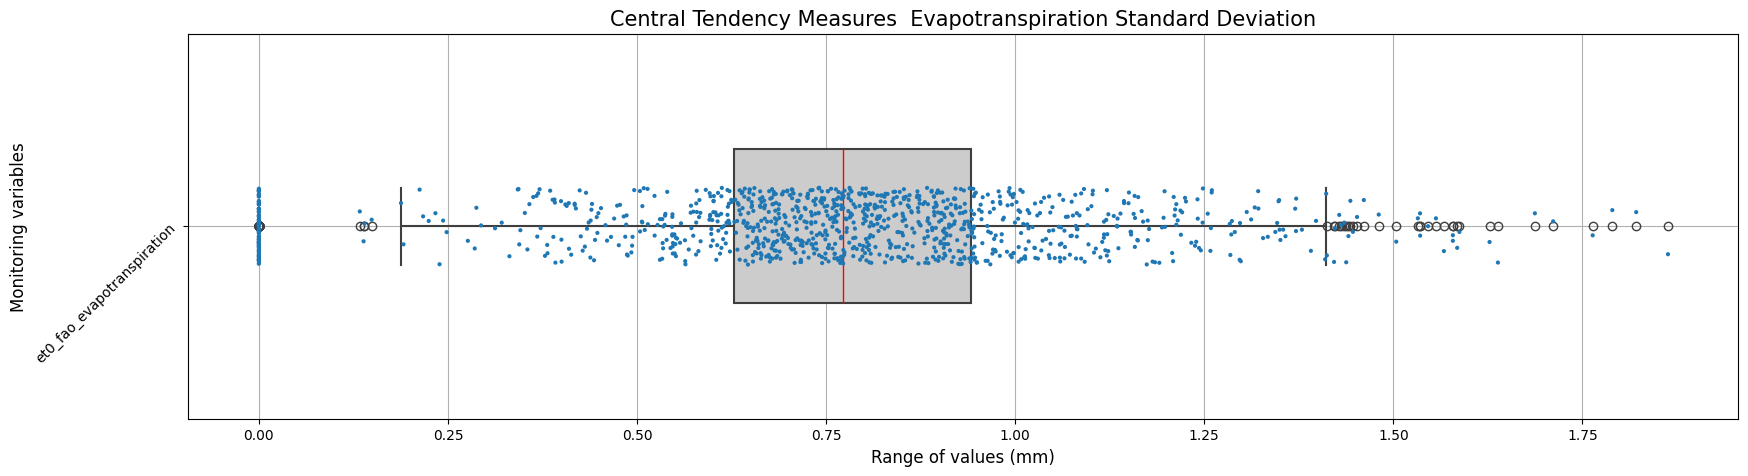

In [114]:
generate_bsplot(
    dataTable=_data[['et0_fao_evapotranspiration']],
    title="Central Tendency Measures  Evapotranspiration Standard Deviation",
    xlabel="mm"
    )

## Covariance

In [115]:
_data = df.groupby(['time']).mean().cov()
display(_data)

temperature_2m_max  temperature_2m_min  \
temperature_2m_max                    17.636062           15.878959   
temperature_2m_min                    15.878959           19.175364   
temperature_2m_mean                   16.810655           17.526887   
apparent_temperature_max              21.719738           21.577762   
apparent_temperature_min              19.684542           24.404437   
apparent_temperature_mean             20.888032           23.048784   
precipitation_sum                     -2.501223            1.440011   
rain_sum                              -2.247910            1.573259   
snowfall_sum                          -0.182296           -0.096275   
precipitation_hours                   -3.650446            2.017478   
wind_speed_10m_max                    -2.287389           -4.075684   
wind_gusts_10m_max                    -0.291574            0.480956   
wind_direction_10m_dominant          -45.620531          -44.879570   
shortwave_radiation_sum                6.205323            4.244363   
et0_fao_evapotranspiration             2.130726            1.594439   

                             temperature_2m_mean  apparent_temperature_max  \
temperature_2m_max                     16.810655                 21.719738   
temperature_2m_min                     17.526887                 21.577762   
temperature_2m_mean                    17.288936                 21.714840   
apparent_temperature_max               21.714840                 28.759585   
apparent_temperature_min               22.024929                 27.513915   
apparent_temperature_mean              22.099248                 28.204461   
precipitation_sum                      -0.706339                 -0.927998   
rain_sum                               -0.504709                 -0.650612   
snowfall_sum                           -0.145218                 -0.200555   
precipitation_hours                    -1.021115                 -1.224149   
wind_speed_10m_max                     -3.471461                 -6.358696   
wind_gusts_10m_max                     -0.287616                 -3.284808   
wind_direction_10m_dominant           -45.746367                -53.532035   
shortwave_radiation_sum                 5.386191                  9.169408   
et0_fao_evapotranspiration              1.897247                  2.733427   

                             apparent_temperature_min  \
temperature_2m_max                          19.684542   
temperature_2m_min                          24.404437   
temperature_2m_mean                         22.024929   
apparent_temperature_max                    27.513915   
apparent_temperature_min                    31.540740   
apparent_temperature_mean                   29.524771   
precipitation_sum                            2.533948   
rain_sum                                     2.687806   
snowfall_sum                                -0.111535   
precipitation_hours                          3.768028   
wind_speed_10m_max                          -6.850038   
wind_gusts_10m_max                          -0.989419   
wind_direction_10m_dominant                -53.159154   
shortwave_radiation_sum                      5.897698   
et0_fao_evapotranspiration                   2.003353   

                             apparent_temperature_mean  precipitation_sum  \
temperature_2m_max                           20.888032          -2.501223   
temperature_2m_min                           23.048784           1.440011   
temperature_2m_mean                          22.099248          -0.706339   
apparent_temperature_max                     28.204461          -0.927998   
apparent_temperature_min                     29.524771           2.533948   
apparent_temperature_mean                    29.076290           0.423393   
precipitation_sum                             0.423393           9.608172   
rain_sum                                      0.650329           9.418660   
snowfall_sum                         

### Data visualization with processing

> Temperature

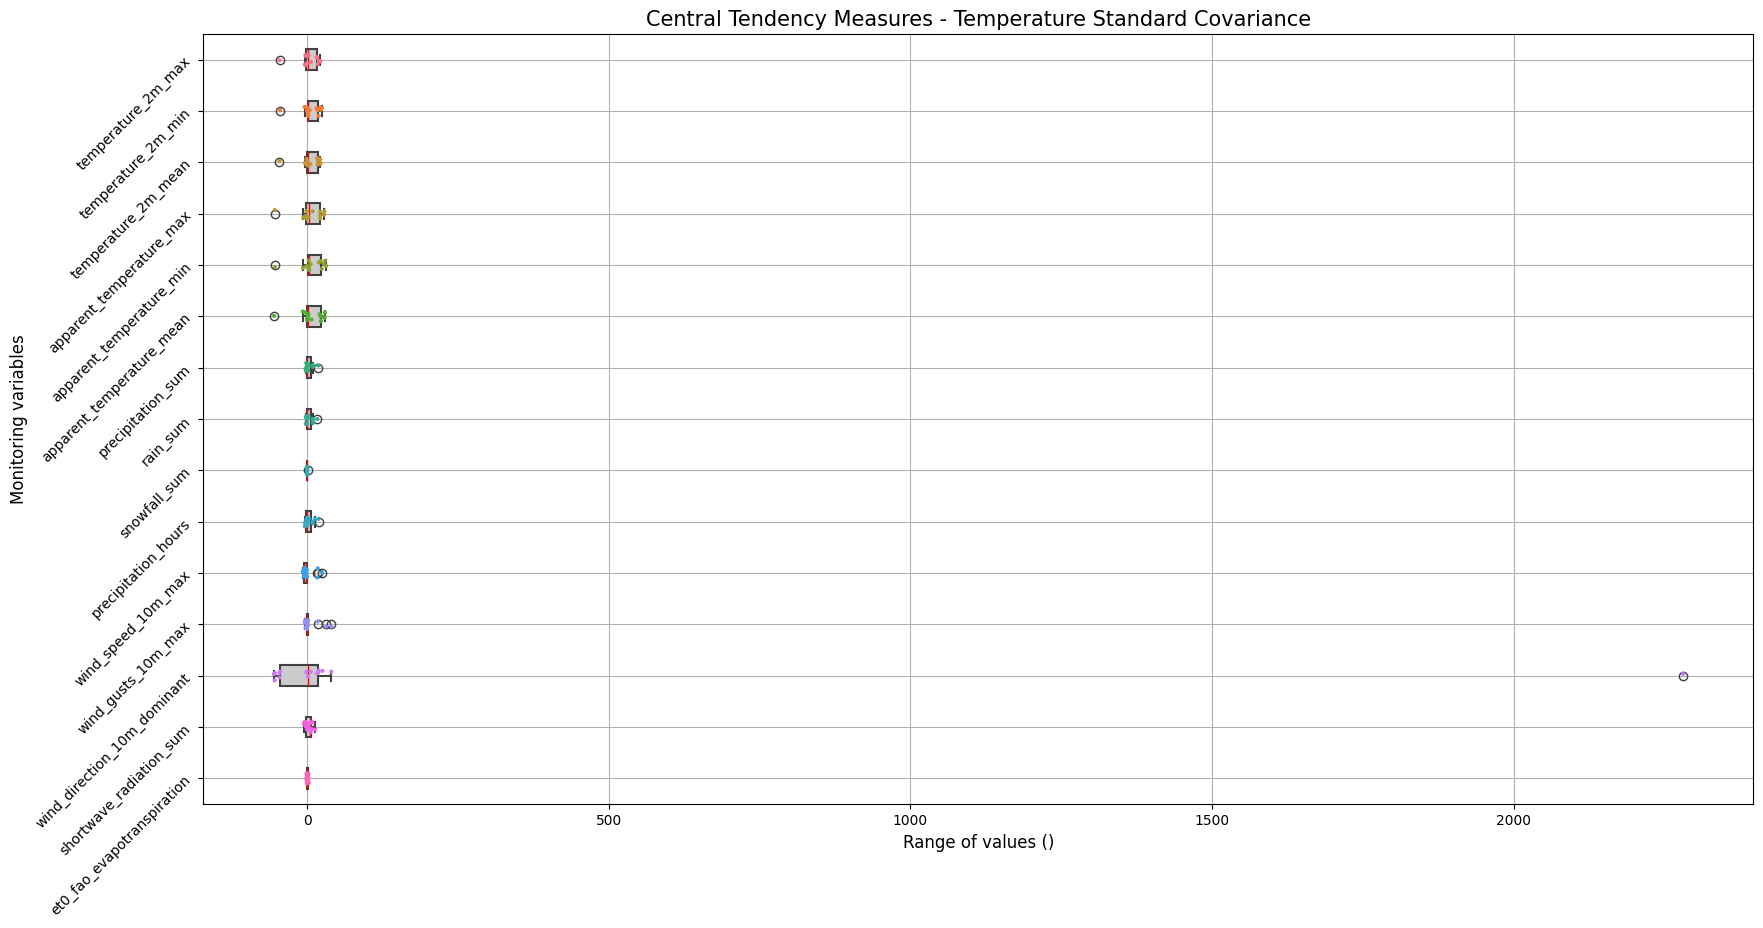

In [116]:
generate_bsplot(
    dataTable=_data.query("wind_direction_10m_dominant < 2500"),
    title="Central Tendency Measures - Temperature Standard Covariance",
    xlabel="",
    width=20,
    heigth=10
    )

##Correlation

In [117]:
_data = df.groupby(['time']).mean().corr()
display(_data)

temperature_2m_max  temperature_2m_min  \
temperature_2m_max                     1.000000            0.863474   
temperature_2m_min                     0.863474            1.000000   
temperature_2m_mean                    0.962719            0.962607   
apparent_temperature_max               0.964412            0.918847   
apparent_temperature_min               0.834620            0.992341   
apparent_temperature_mean              0.922417            0.976128   
precipitation_sum                     -0.192146            0.106090   
rain_sum                              -0.175574            0.117845   
snowfall_sum                          -0.238289           -0.120690   
precipitation_hours                   -0.243263            0.128934   
wind_speed_10m_max                    -0.133083           -0.227411   
wind_gusts_10m_max                    -0.012455            0.019703   
wind_direction_10m_dominant           -0.227495           -0.214629   
shortwave_radiation_sum                0.402340            0.263919   
et0_fao_evapotranspiration             0.663443            0.476116   

                             temperature_2m_mean  apparent_temperature_max  \
temperature_2m_max                      0.962719                  0.964412   
temperature_2m_min                      0.962607                  0.918847   
temperature_2m_mean                     1.000000                  0.973826   
apparent_temperature_max                0.973826                  1.000000   
apparent_temperature_min                0.943180                  0.913535   
apparent_temperature_mean               0.985653                  0.975342   
precipitation_sum                      -0.054804                 -0.055826   
rain_sum                               -0.039814                 -0.039794   
snowfall_sum                           -0.191719                 -0.205292   
precipitation_hours                    -0.068726                 -0.063881   
wind_speed_10m_max                     -0.203991                 -0.289707   
wind_gusts_10m_max                     -0.012409                 -0.109882   
wind_direction_10m_dominant            -0.230401                 -0.209043   
shortwave_radiation_sum                 0.352717                  0.465564   
et0_fao_evapotranspiration              0.596646                  0.666489   

                             apparent_temperature_min  \
temperature_2m_max                           0.834620   
temperature_2m_min                           0.992341   
temperature_2m_mean                          0.943180   
apparent_temperature_max                     0.913535   
apparent_temperature_min                     1.000000   
apparent_temperature_mean                    0.974947   
precipitation_sum                            0.145560   
rain_sum                                     0.156980   
snowfall_sum                                -0.109019   
precipitation_hours                          0.187763   
wind_speed_10m_max                          -0.298016   
wind_gusts_10m_max                          -0.031605   
wind_direction_10m_dominant                 -0.198223   
shortwave_radiation_sum                      0.285941   
et0_fao_evapotranspiration                   0.466443   

                             apparent_temperature_mean  precipitation_sum  \
temperature_2m_max                            0.922417          -0.192146   
temperature_2m_min                            0.976128           0.106090   
temperature_2m_mean                           0.985653          -0.054804   
apparent_temperature_max                      0.975342          -0.055826   
apparent_temperature_min                      0.974947           0.145560   
apparent_temperature_mean                     1.000000           0.025331   
precipitation_sum                             0.025331           1.000000   
rain_sum                                      0.039559           0.996669   
snowfall_sum                         

### Data visualization with processing

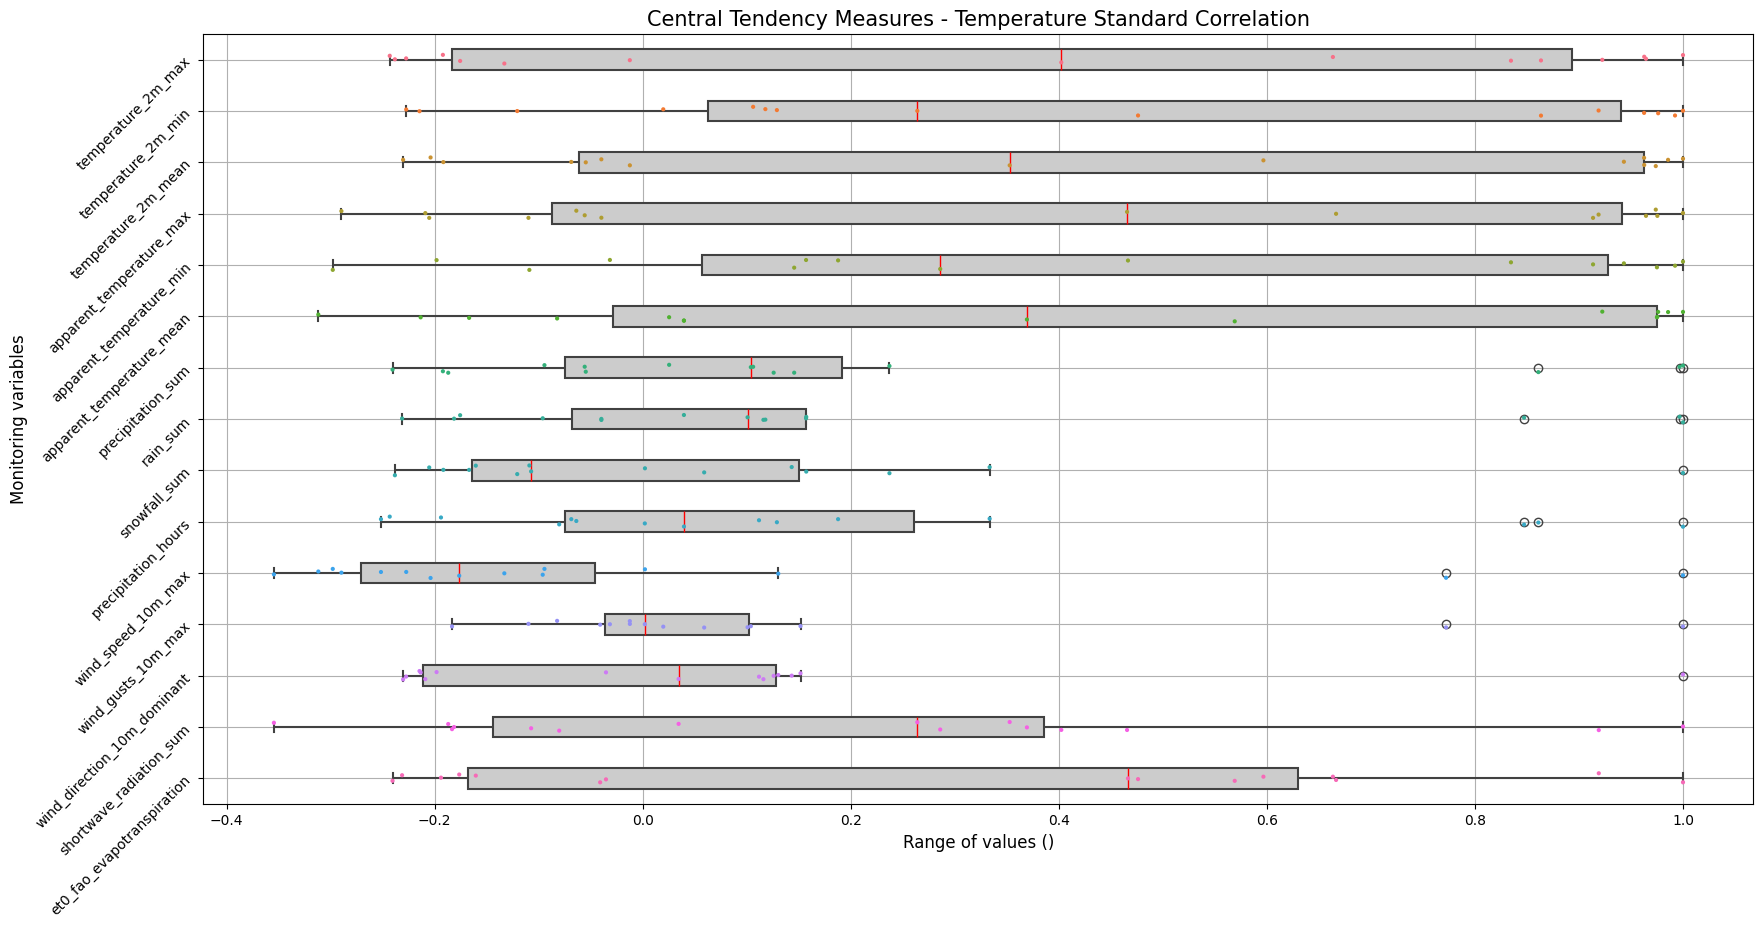

In [118]:
generate_bsplot(
    dataTable=_data,
    title="Central Tendency Measures - Temperature Standard Correlation",
    xlabel="",
    width=20,
    heigth=10
    )